In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

import unicodedata
import re
import os
import io

np.random.seed(42)
tf.random.set_seed(42)

path1 = '/content/drive/MyDrive/targetlang.txt'
path2='/content/drive/MyDrive/sourcelang.txt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

def preprocess(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)
    s = s.strip()
    # adding start-of-sequence (sos) token and end-of-sequence (eos) token
    s = '<sos> ' + s + ' <eos>'
    return s

In [ ]:
def tokenize(language):
    # Use <unk> token for unkown words
    tokenizer = Tokenizer(filters='', oov_token='<unk>')
    tokenizer.fit_on_texts(language)

    tensor = tokenizer.texts_to_sequences(language)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

def load_dataset(path1,path2 ,num_examples=None, prints=False) :
    lines = open(path1, encoding='UTF-8').read().strip().split('\n')
    lines2 = open(path2, encoding='UTF-8').read().strip().split('\n')
    
    # list containing word pairs in the format: [[ENGLISH], [FRENCH]]
    word_pairs = [preprocess(l) for l in lines[:num_examples]]
    input_lang=word_pairs
    word_pairs2 = [preprocess(l) for l in lines2[:num_examples]]
    targ_lang=word_pairs2

    if prints:
        print(input_lang[-1])
        print(targ_lang[-1])
        return
    
    input_tensor, input_tokenizer = tokenize(input_lang)
    targ_tensor, targ_tokenizer = tokenize(targ_lang)

    return input_tensor, targ_tensor, input_tokenizer, targ_tokenizer

load_dataset(path1,path2,num_examples=85221, prints=True)

<sos> was naqash his empty glass toyed . <eos>
<sos> naqash toyed with his empty glass . <eos>


In [ ]:
inp_tensor, targ_tensor, inp_lang, targ_lang = load_dataset(path1,path2)
inp_tensor_train, inp_tensor_val, \
targ_tensor_train, targ_tensor_val = \
train_test_split(inp_tensor, targ_tensor, test_size=0.2)
print("Input tensors: ", inp_tensor_train.shape, inp_tensor_val.shape)
print("Target tensors: ", targ_tensor_train.shape, targ_tensor_val.shape)

Input tensors:  (68176, 17) (17044, 17)
Target tensors:  (68176, 15) (17044, 15)


In [ ]:
buffer_size = len(inp_tensor_train)
batch_size = 64
steps_per_epoch = len(inp_tensor_train) // batch_size
embedding_dim = 300
units = 1024 
vocab_inp_size = len(inp_lang.index_word) + 1
vocab_targ_size = len(targ_lang.index_word) + 1

def create_dataset(shuffle=True, buffer_size=buffer_size, batch_size=batch_size):
    ds = tf.data.Dataset.from_tensor_slices((inp_tensor_train, targ_tensor_train))
    if shuffle:
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds.prefetch(1)

train_dataset = create_dataset()
valid_dataset = create_dataset(shuffle=False)
inp_batch, targ_batch = next(iter(train_dataset))
inp_batch.shape, targ_batch.shape

(TensorShape([64, 17]), TensorShape([64, 15]))

In [ ]:
def gru(units):
    
    '''
    Args: 
        units: number of units
    Return:
        GRU units
    
    If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
    the code automatically does that.
    '''
    return tf.keras.layers.GRU(units, 
                                return_sequences=True, 
                                return_state=True, 
                                recurrent_activation='sigmoid', 
                                recurrent_initializer='glorot_uniform')

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, dot, Dense,GRU

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size= batch_size
        self.encoder_units=encoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru= tf.keras.layers.GRU(encoder_units, 
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform'
                                     )
    
    def call(self, x, hidden):
        #pass the input x to the embedding layer
        x= self.embedding(x)
        # pass the embedding and the hidden state to GRU
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))


encoder = Encoder(vocab_inp_size,embedding_dim,units,batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden= encoder(inp_batch,sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
def print_shapes(enc_output, dec_state, score, attention_weights, context_vector):
    print(f"btach_size: {batch_size}")
    print(f"seq_length: {inp_tensor_train.shape[1]}")
    print(f"enc_units: {units}")
    print()
    print(f"enc_output:        {enc_output.shape}")
    print(f"dec_state:         {dec_state.shape}")
    print(f"score:             {score.shape}")
    print(f"attention_weights: {attention_weights.shape}")
    print(f"context_vector:    {context_vector.shape}")

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super( BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units)  # encoder output
        self.W2= tf.keras.layers.Dense(units)  # Decoder hidden
        self.V= tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        #calculate the Attention score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score= self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights= tf.nn.softmax(score, axis=1)
        
         #context_vector 
        context_vector= attention_weights * values
       
        #Computes the sum of elements across dimensions of a tensor
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

attention_layer= BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden,sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoder_units, batch_sz):
        super (Decoder,self).__init__()
        self.batch_sz= batch_sz
        self.decoder_units = decoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru= tf.keras.layers.GRU(decoder_units, 
                                      return_sequences= True,
                                      return_state=True,
                          recurrent_initializer='glorot_uniform')
        # Fully connected layer
        self.fc= tf.keras.layers.Dense(vocab_size)
        
        # attention
        self.attention = BahdanauAttention(self.decoder_units)
    
    def call(self, x, hidden, encoder_output):
        
        context_vector, attention_weights = self.attention(hidden,      
                                                    encoder_output)
        
        # pass output sequnece thru the input layers
        x= self.embedding(x)
        
        # concatenate context vector and embedding for output sequence
        x= tf.concat([tf.expand_dims( context_vector, 1), x], 
                                      axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output= tf.reshape(output, (-1, output.shape[2]))
        
        # pass the output thru Fc layers
        x= self.fc(output)
        return x, state, attention_weights


decoder= Decoder(vocab_targ_size,embedding_dim, units, batch_size)
sample_decoder_output, _, _= decoder(tf.random.uniform((batch_size,1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 9262)


In [ ]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()

In [ ]:
def print_status_bar(iteration, total, loss):    
    metrics = "loss: {:.4f}".format(loss) 
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,end=end)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        #create encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        #first input to decode is start_
        dec_input = tf.expand_dims(
            [target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          # calculate loss based on predictions  
          loss += tf.keras.losses.sparse_categorical_crossentropy(targ[:, t], predictions)
          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp_batch, targ_batch, enc_state_h):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_state_h = encoder(inp_batch, enc_state_h)
        # at the beginning we set the decoder state to the encoder state
        dec_state_h= enc_state_h

        # at the begining we feed the <sos> token as input for the decoder, 
        # then we will feed the target as input
        dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * batch_size, 1)
        for t in range(1, targ_batch.shape[1]): # targ_batch.shape[1] == seq length
            predictions, dec_state_h,_ = decoder(dec_input, dec_state_h, enc_output)
            loss += loss_function(targ_batch[:, t], predictions)
            dec_input = tf.expand_dims(targ_batch[:, t], 1)
        
    batch_loss = loss / int(targ_batch.shape[1])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [ ]:
EPOCHS=6
for epoch in range(EPOCHS):
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # train the model using data in bataches 
  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {}'.format(epoch + 1,batch,batch_loss.numpy()))
  print('Epoch {} Loss {}'.format(epoch + 1,total_loss / steps_per_epoch))

Epoch 1 Batch 0 Loss 4.633101940155029
Epoch 1 Batch 100 Loss 2.2997689247131348
Epoch 1 Batch 200 Loss 2.0830564498901367
Epoch 1 Batch 300 Loss 1.9148143529891968
Epoch 1 Batch 400 Loss 1.933480978012085
Epoch 1 Batch 500 Loss 1.5365939140319824
Epoch 1 Batch 600 Loss 1.4107484817504883
Epoch 1 Batch 700 Loss 1.272682785987854
Epoch 1 Batch 800 Loss 1.3104280233383179
Epoch 1 Batch 900 Loss 1.0368146896362305
Epoch 1 Batch 1000 Loss 0.9891964197158813
Epoch 1 Loss 1.5810160636901855
Epoch 2 Batch 0 Loss 0.7636850476264954
Epoch 2 Batch 100 Loss 0.7723216414451599
Epoch 2 Batch 200 Loss 0.6403431296348572
Epoch 2 Batch 300 Loss 0.5509923100471497
Epoch 2 Batch 400 Loss 0.4653593599796295
Epoch 2 Batch 500 Loss 0.4871157705783844
Epoch 2 Batch 600 Loss 0.47610411047935486
Epoch 2 Batch 700 Loss 0.43194159865379333
Epoch 2 Batch 800 Loss 0.4316994547843933
Epoch 2 Batch 900 Loss 0.42651066184043884
Epoch 2 Batch 1000 Loss 0.40633881092071533
Epoch 2 Loss 0.5223032832145691
Epoch 3 Batch

In [ ]:
def evaluate(sentence, targ_tensor, inp_tensor):
    # targ_tensor.shape[1] == max seq length for the target language (EN)
    # inp_tensor.shape[1] == max seq length for the input language (FR)
    attention_plot = np.zeros((targ_tensor.shape[1], inp_tensor.shape[1]))
    
    sentence = preprocess(sentence)

    inputs = inp_lang.texts_to_sequences([sentence])
    inputs = pad_sequences(inputs, maxlen=inp_tensor.shape[1], padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    enc_state_h= tf.zeros((1, units))
    enc_output, enc_state_h= encoder(inputs, enc_state_h)
    dec_state_h= enc_state_h
    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

    for t in range(targ_tensor.shape[1]):
        predictions, dec_state_h,attention_weights = decoder(dec_input,dec_state_h,enc_output)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        # stop prediction
        if targ_lang.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot


In [ ]:
# function for plotting the attention weights to visualize how the model works internally
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
    
  ax.set_xticklabels([''] + sentence, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence)

  plt.show()


def translate(sentence, ground_truth=None, plot_weights=True):
    result, sentence, attention_plot = evaluate(sentence, targ_tensor, inp_tensor)

    print(f'{"Input:":15s} {sentence}')
    print(f'{"Prediction:":15s} {result}')
    if ground_truth: print(f'{"Ground truth:":15s} {ground_truth}') 
    
    if plot_weights:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
def gettranslation(sentence, ground_truth=None, plot_weights=True):
    result, sentence, attention_plot = evaluate(sentence, targ_tensor, inp_tensor)

    # print(f'{"Input:":15s} {sentence}')
    # print(f'{"Prediction:":15s} {result}')
    # if ground_truth: print(f'{"Ground truth:":15s} {ground_truth}') 
    
    if plot_weights:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

    return sentence,result,ground_truth

In [ ]:
def preprocess_sequence(seq, language):
    sentence = language.sequences_to_texts([seq.numpy()])[0]
    sentence = sentence.split(' ')
    sentence = [s for s in sentence if s != '<sos>' and s != '<eos>' and s != '<unk>']
    return ' '.join(sentence)

Input:          <sos> moon hardly his age ever act . <eos>
Prediction:     moon hardly ever acts his age . <eos> 
Ground truth:   moon hardly ever acts his age .


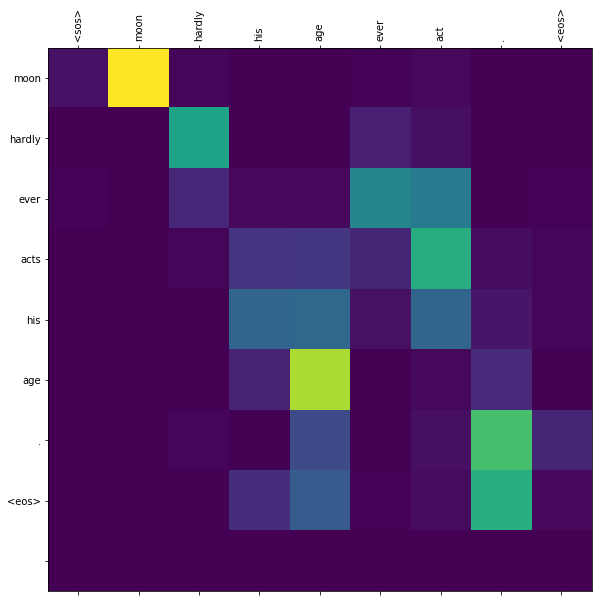


Input:          <sos> was he even goodbye say not . <eos>
Prediction:     he did not even say goodbye . <eos> 
Ground truth:   he did not even say goodbye .


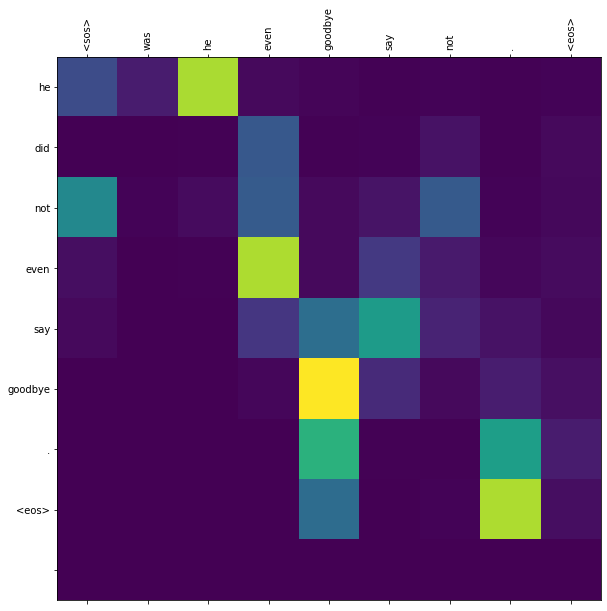


Input:          <sos> i do after as was you suggest . <eos>
Prediction:     i will do as you suggested . <eos> 
Ground truth:   i will do as you suggested .


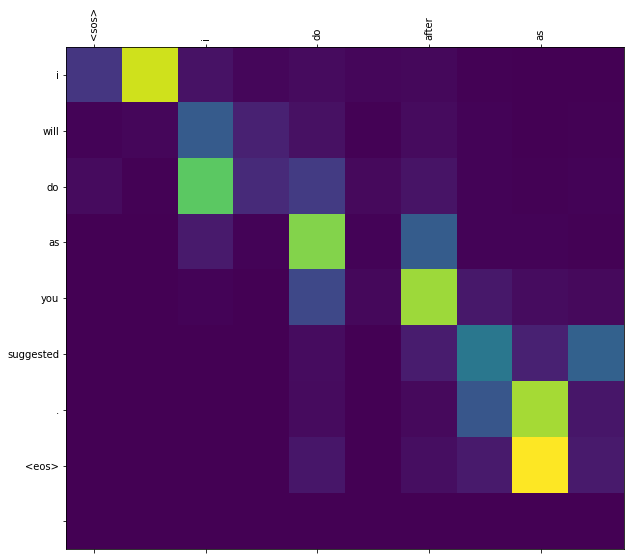


Input:          <sos> they soon enough one get after . <eos>
Prediction:     they will soon get one soon soon enough . <eos> 
Ground truth:   they will get one soon enough .


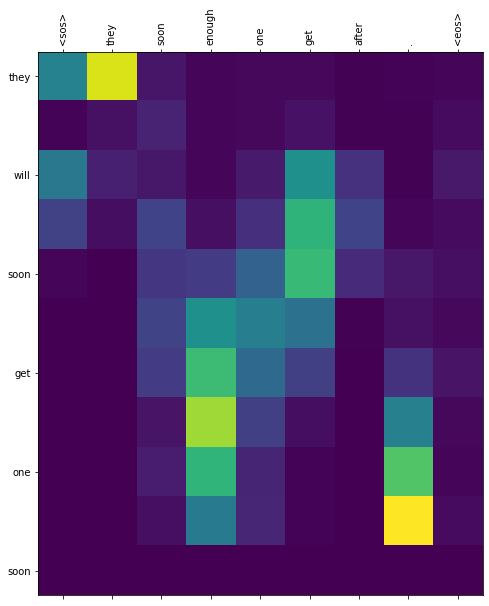


Input:          <sos> just home go back . <eos>
Prediction:     just go back home . <eos> 
Ground truth:   just go back home .


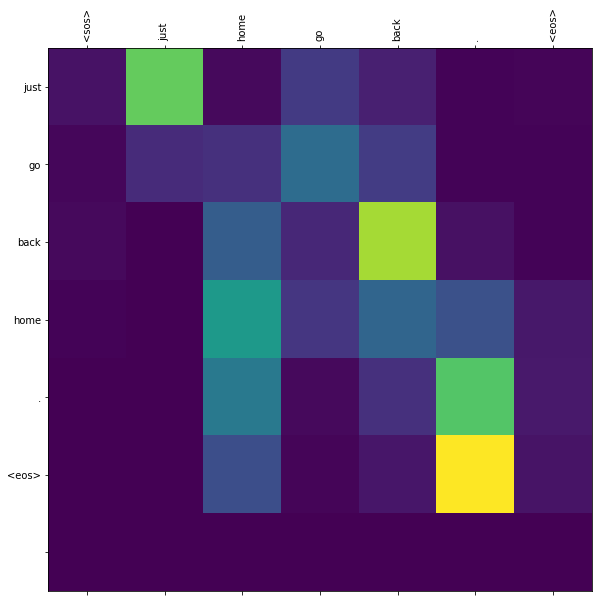


Input:          <sos> was she cry as she letter read . <eos>
Prediction:     she cried as she read the letter . <eos> 
Ground truth:   she cried as she read the letter .


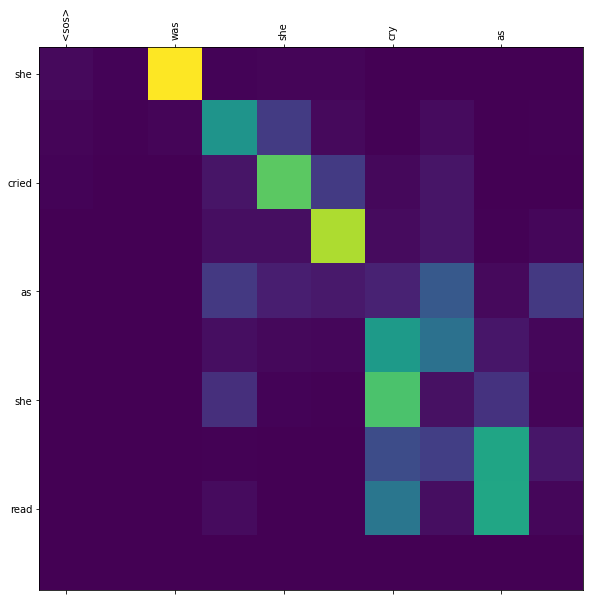


Input:          <sos> hafeez very well look now not . <eos>
Prediction:     hafeez is not looking very well . <eos> 
Ground truth:   hafeez is not looking very well .


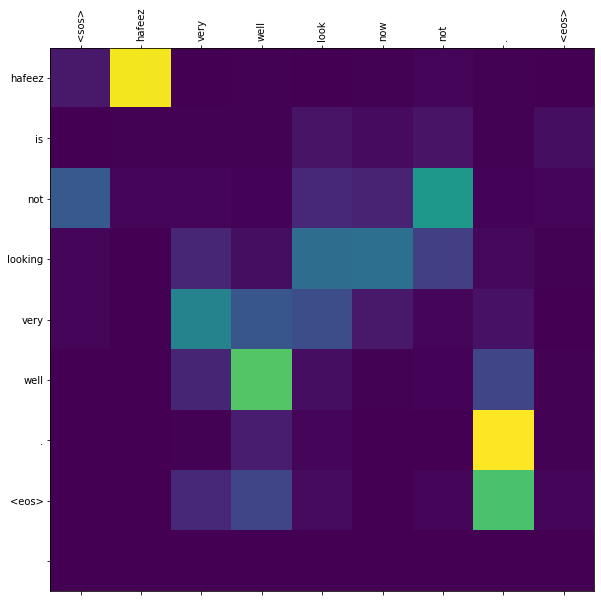


Input:          <sos> amir just television watch now . <eos>
Prediction:     amir is just watching television . <eos> 
Ground truth:   amir is just watching television .


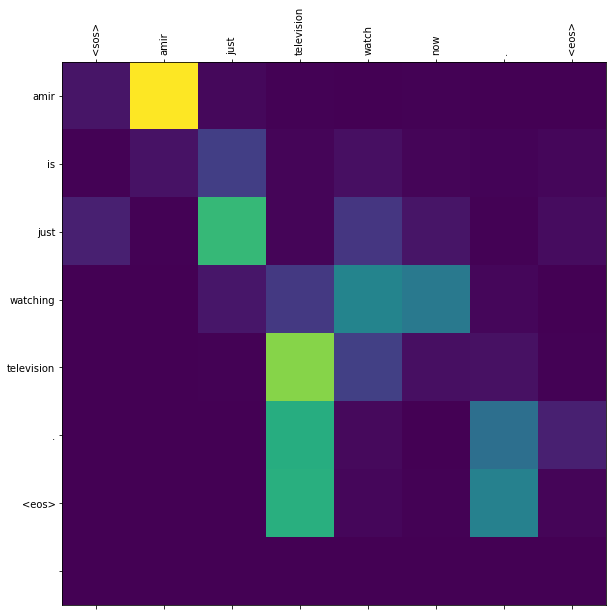


Input:          <sos> was moon my homework copy want . <eos>
Prediction:     moon wanted to copy my homework . <eos> 
Ground truth:   moon wanted to copy my homework .


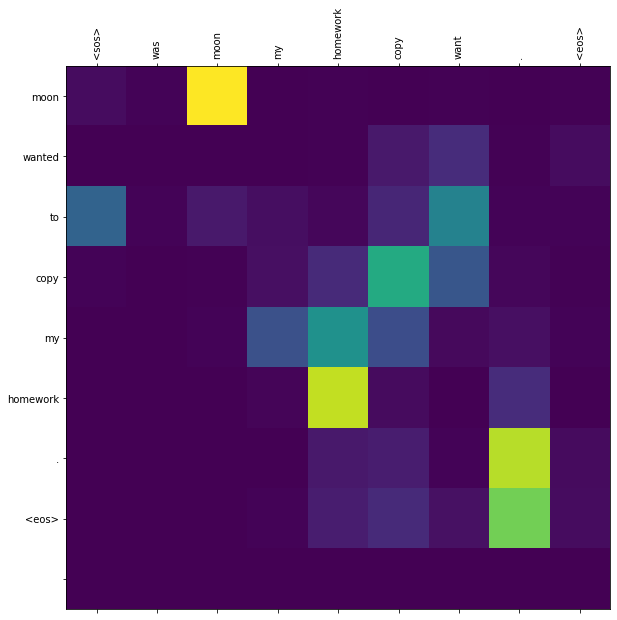


Input:          <sos> i good news get full . <eos>
Prediction:     i have got good news . <eos> 
Ground truth:   i have got some good news .


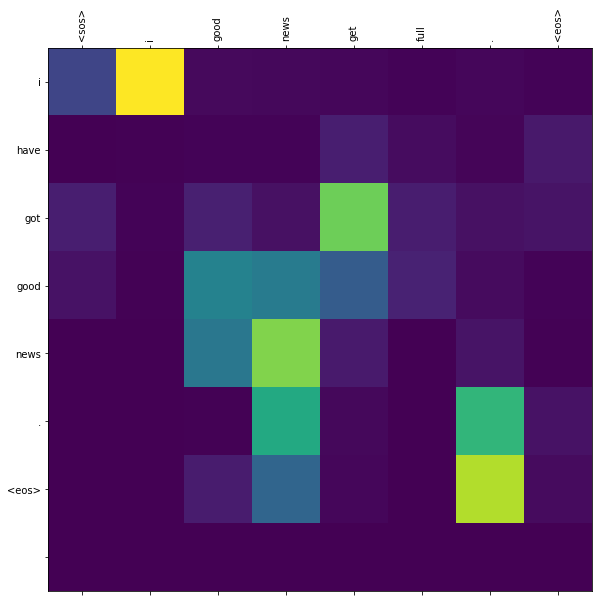


Input:          <sos> was i your book show want . <eos>
Prediction:     i wanted to show you all your book . <eos> 
Ground truth:   i wanted to show uqbah your book .


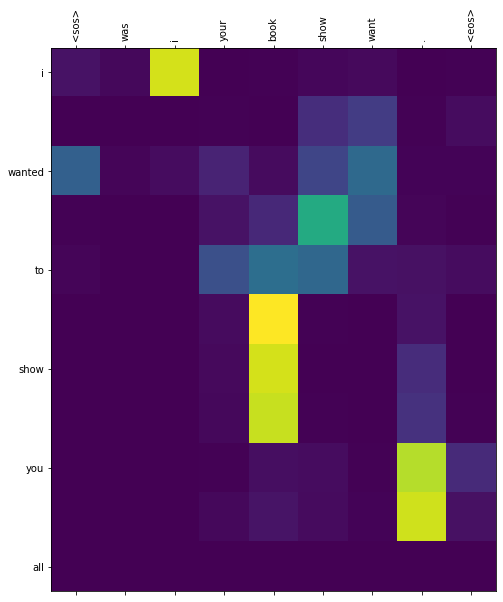


Input:          <sos> was fisherman beach camp on yes no ? <eos>
Prediction:     did fisherman camp on a beach . <eos> 
Ground truth:   did fisherman camp on a beach .


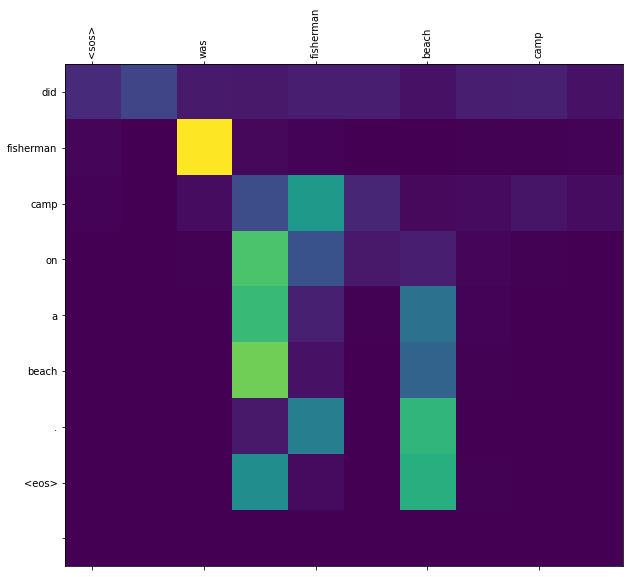


Input:          <sos> was qasim say that adila cry not . <eos>
Prediction:     qasim said that adila would not cry . <eos> 
Ground truth:   qasim said that adila would not cry .


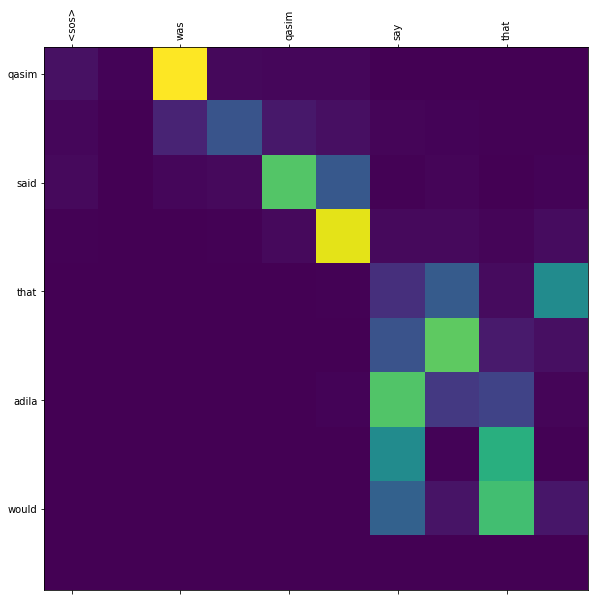


Input:          <sos> was robin his father gazala tell . <eos>
Prediction:     robin told gazala about his father . <eos> 
Ground truth:   robin told gazala about his father .


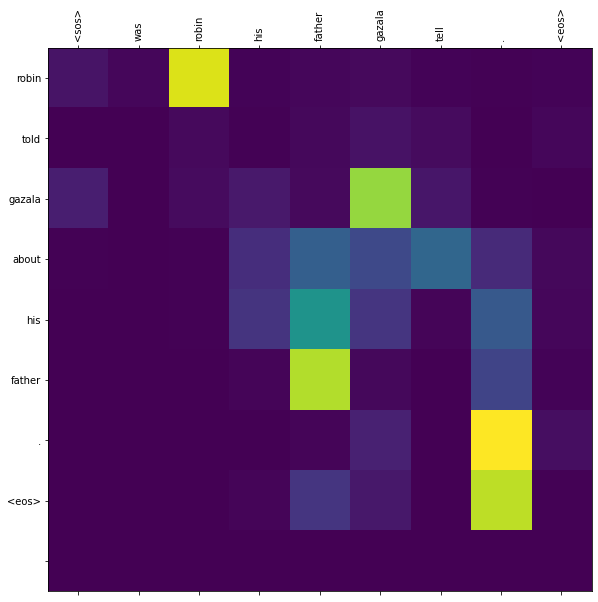


Input:          <sos> ayesha school go now not yes no ? <eos>
Prediction:     is ayesha not going to school . <eos> 
Ground truth:   is ayesha not going to school .


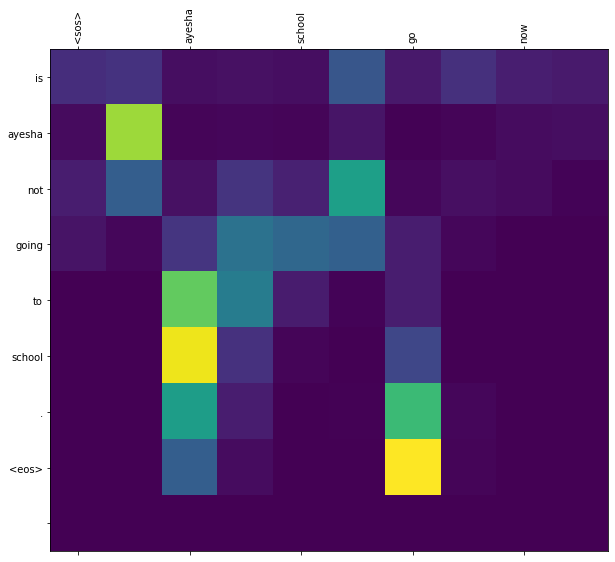


Input:          <sos> it really bad situation . <eos>
Prediction:     it is a really bad situation . <eos> 
Ground truth:   it is a really bad situation .


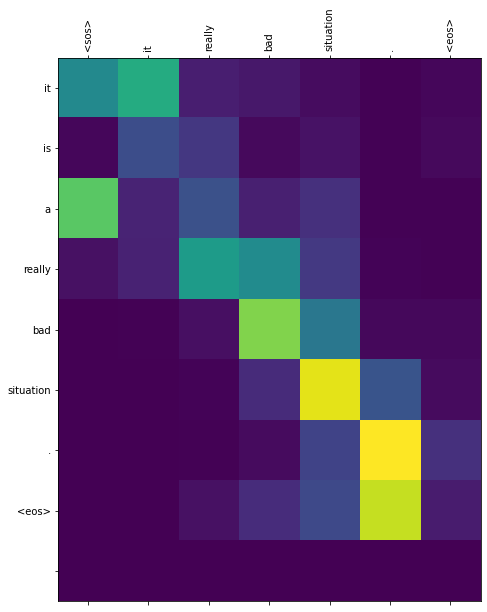


Input:          <sos> was umais halima jail escape help . <eos>
Prediction:     umais and halima helped school in jail . <eos> 
Ground truth:   umais helped halima escape from jail .


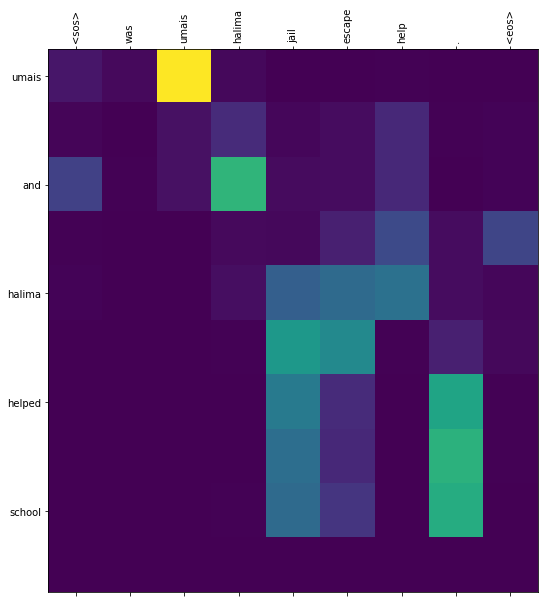


Input:          <sos> was husnain say he recall not . <eos>
Prediction:     husnain said he could not recall . <eos> 
Ground truth:   husnain said he could not recall .


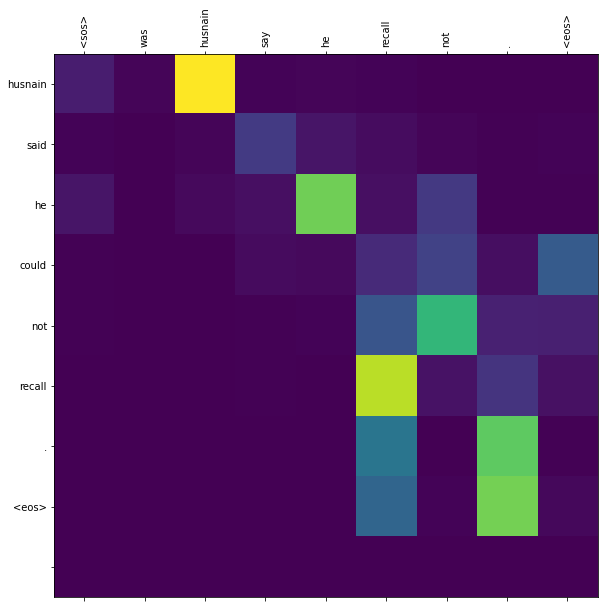


Input:          <sos> i golf play now . <eos>
Prediction:     i am playing golf . <eos> 
Ground truth:   i am playing golf .


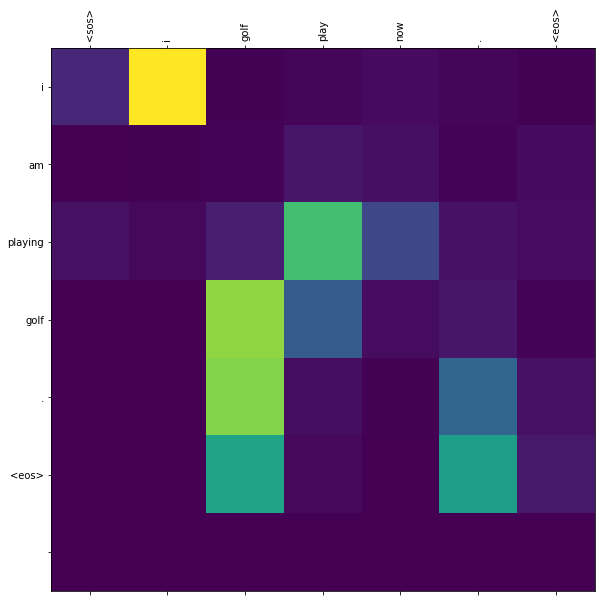


Input:          <sos> he food eat full not . <eos>
Prediction:     he has not eaten food . <eos> 
Ground truth:   he has not eaten food .


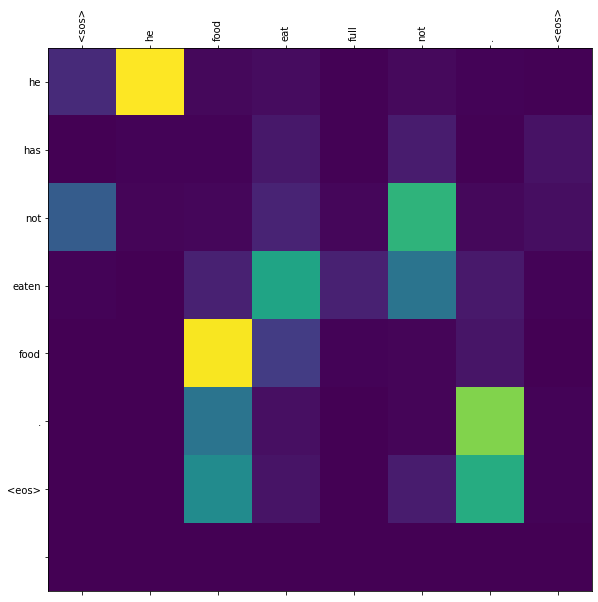


Input:          <sos> was saqib furniture dust full now not yes no ? <eos>
Prediction:     had saqib not been dusting the furniture . <eos> 
Ground truth:   had saqib not been dusting the furniture .


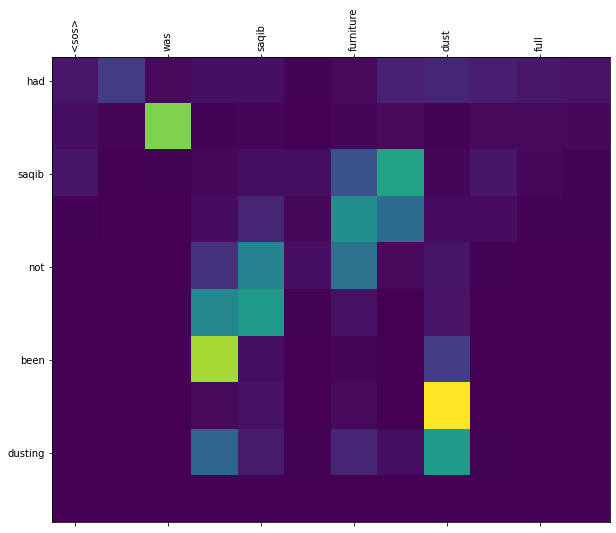


Input:          <sos> was i cup drop . <eos>
Prediction:     i dropped the cup . <eos> 
Ground truth:   i dropped the cup .


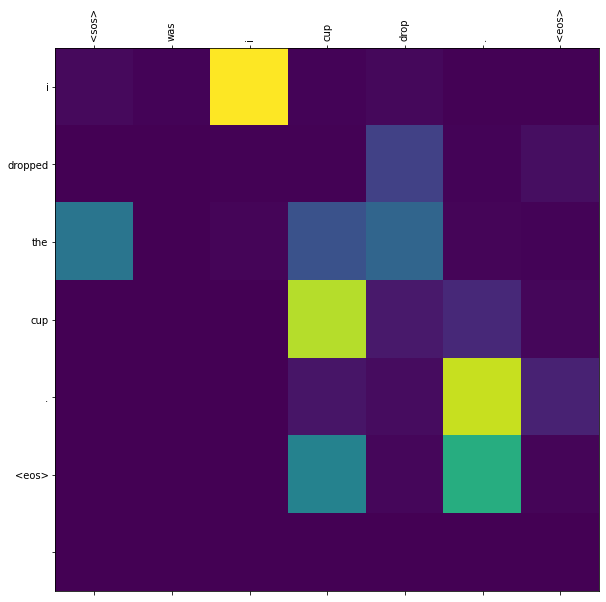


Input:          <sos> he excellent tennis player . <eos>
Prediction:     he is an excellent tennis player . <eos> 
Ground truth:   he is an excellent tennis player .


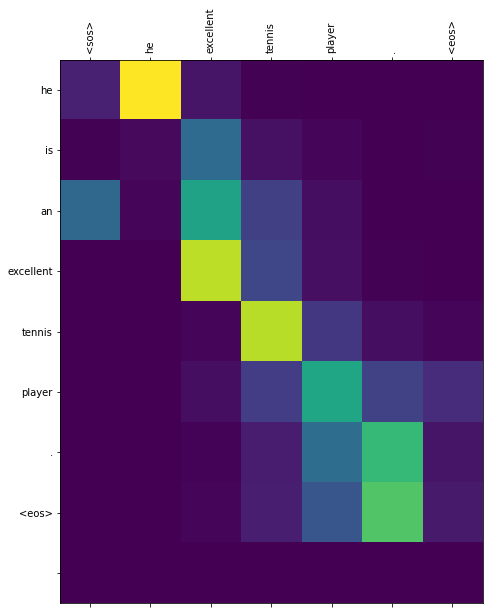


Input:          <sos> outside go . <eos>
Prediction:     go outside . <eos> 
Ground truth:   go outside .


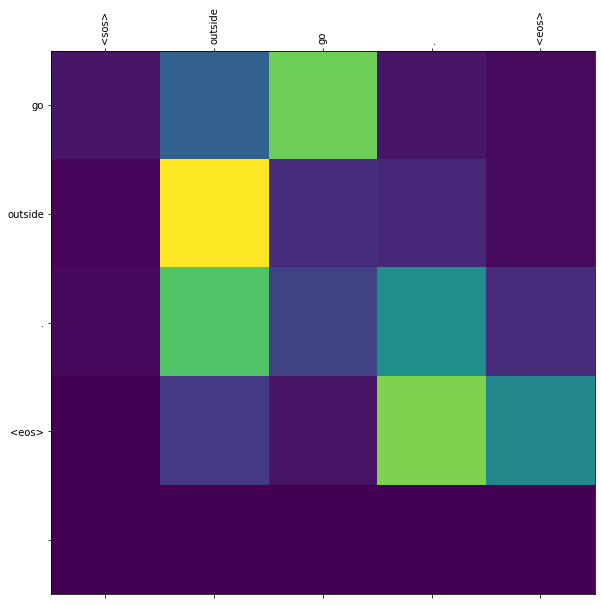


Input:          <sos> you live here anymore not . <eos>
Prediction:     you do not live here anymore . <eos> 
Ground truth:   you can not live here anymore .


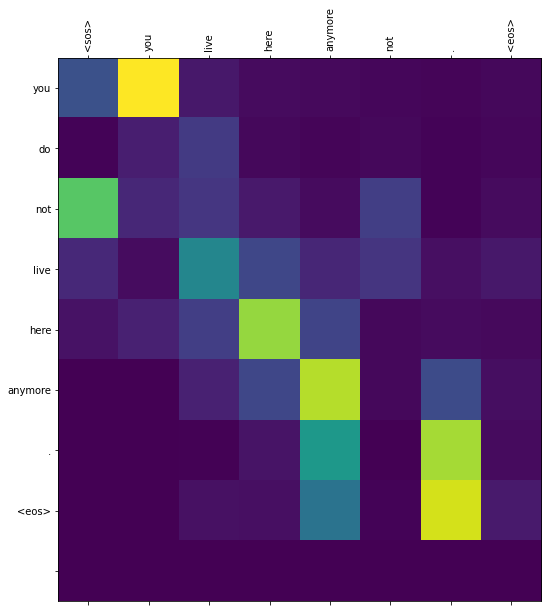


Input:          <sos> your family my best give . <eos>
Prediction:     give my best to your family . <eos> 
Ground truth:   give my best to your family .


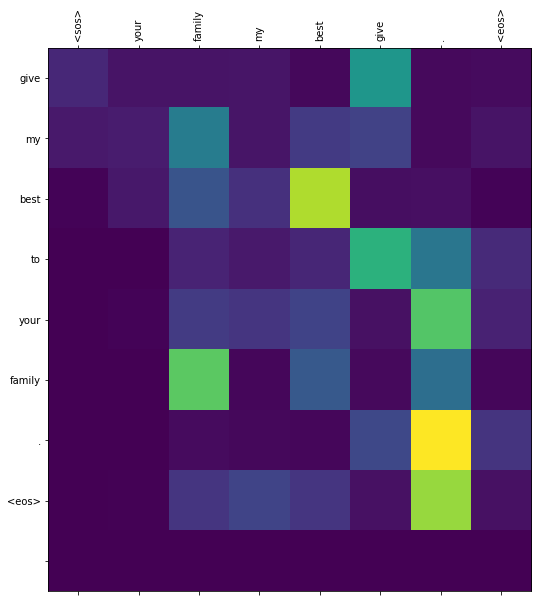


Input:          <sos> was habibullah his anger conceal try . <eos>
Prediction:     habibullah tried to conceal his anger . <eos> 
Ground truth:   habibullah tried to conceal his anger .


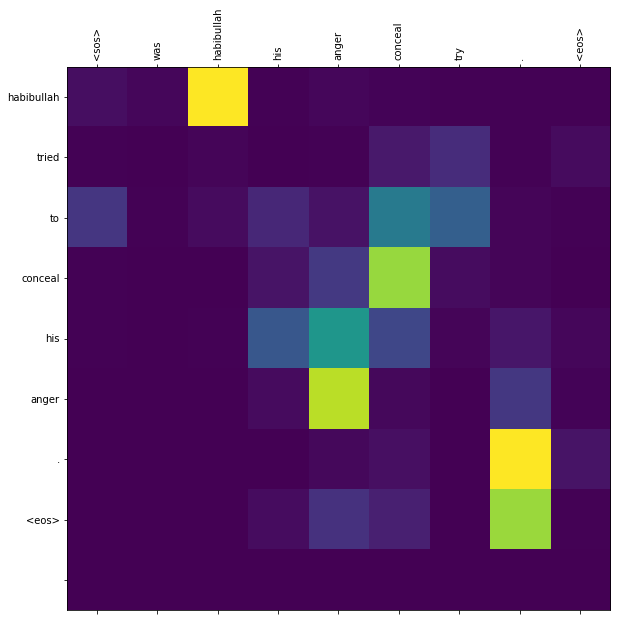


Input:          <sos> buzdar always time here get . <eos>
Prediction:     buzdar always gets here on time . <eos> 
Ground truth:   buzdar always gets here on time .


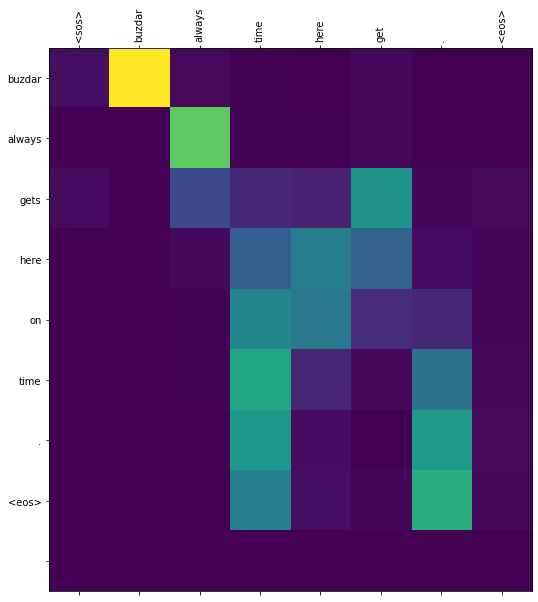


Input:          <sos> i know that shazim naive . <eos>
Prediction:     i know that shazim is naive . <eos> 
Ground truth:   i know that shazim is naive .


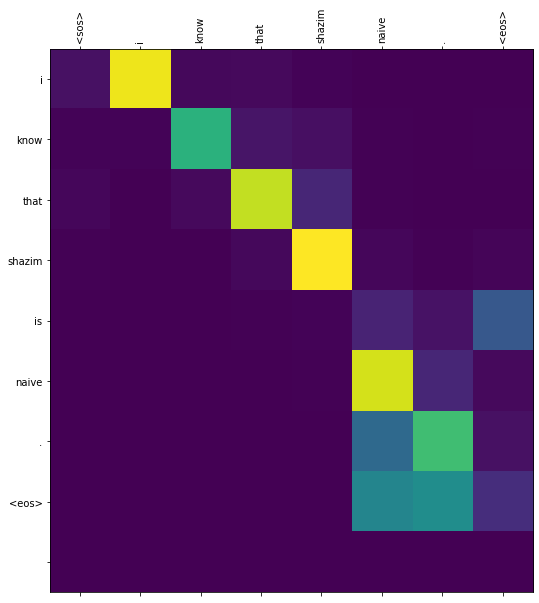


Input:          <sos> was sameer very difficult year had . <eos>
Prediction:     sameer had a very difficult year . <eos> 
Ground truth:   sameer had a very difficult year .


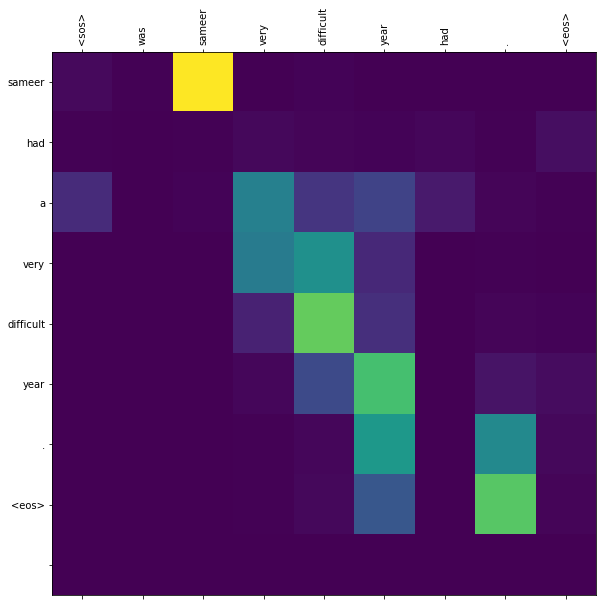


Input:          <sos> was ajab room seal . <eos>
Prediction:     ajab sealed the room . <eos> 
Ground truth:   ajab sealed the room .


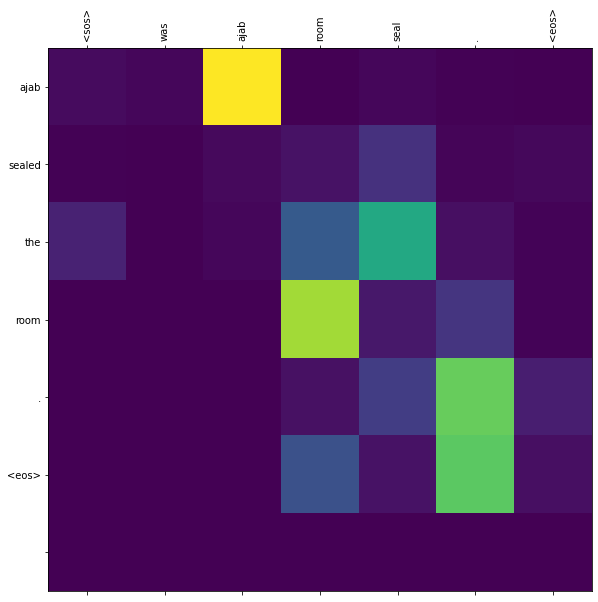


Input:          <sos> sure make you windows close . <eos>
Prediction:     make sure you close the windows . <eos> 
Ground truth:   make sure you close the windows .


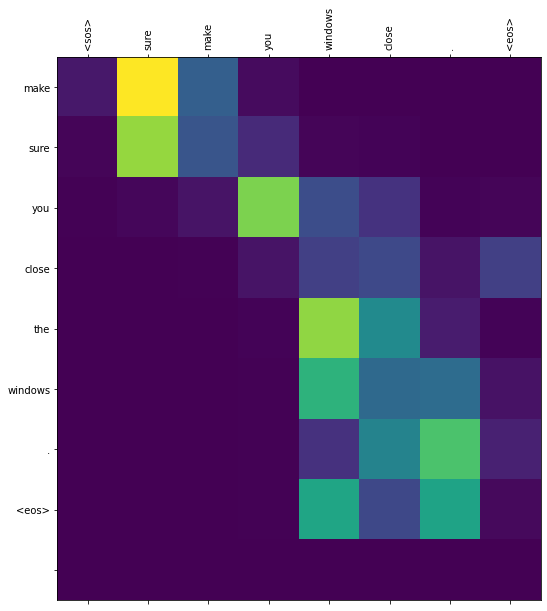


Input:          <sos> i think jamil big advantage has . <eos>
Prediction:     i think jamil has a big advantage . <eos> 
Ground truth:   i think jamil has a big advantage .


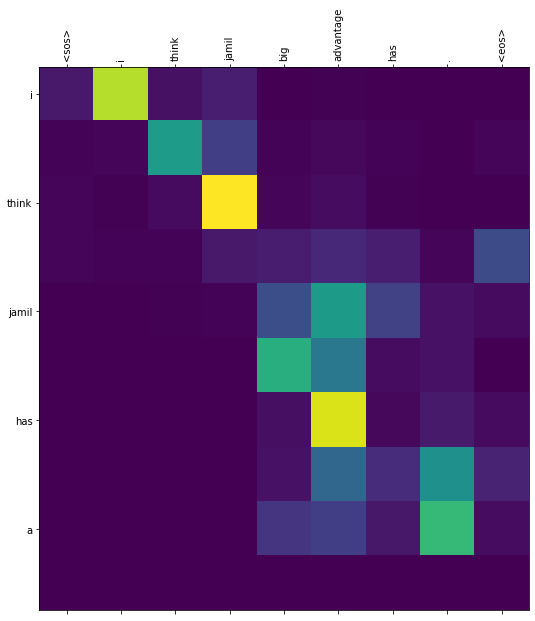


Input:          <sos> was i sohail explain ask . <eos>
Prediction:     i asked sohail to explain . <eos> 
Ground truth:   i asked sohail to explain .


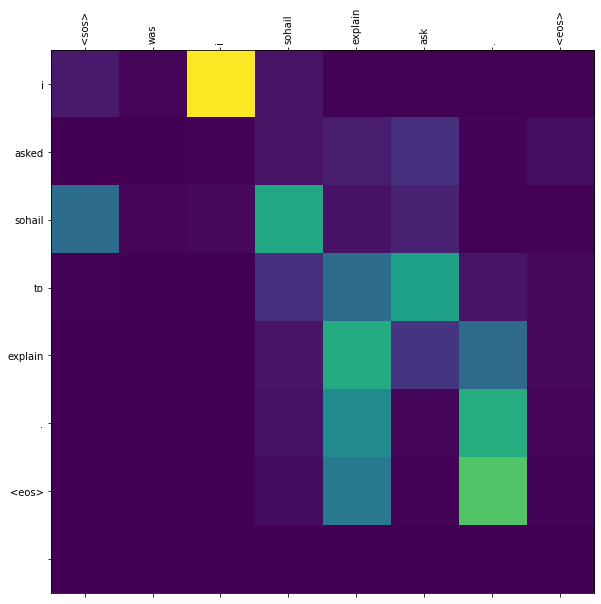


Input:          <sos> idrees my help need . <eos>
Prediction:     idrees needs my help . <eos> 
Ground truth:   idrees needs my help .


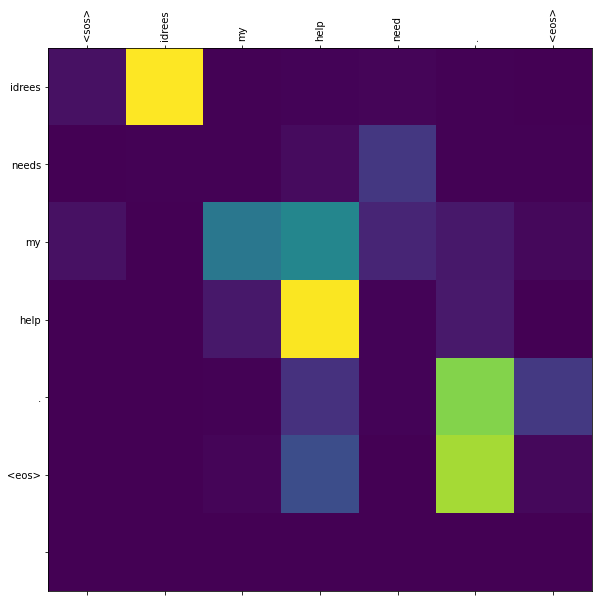


Input:          <sos> we now do after what ? <eos>
Prediction:     what will we done now ? <eos> 
Ground truth:   what will we do now ?


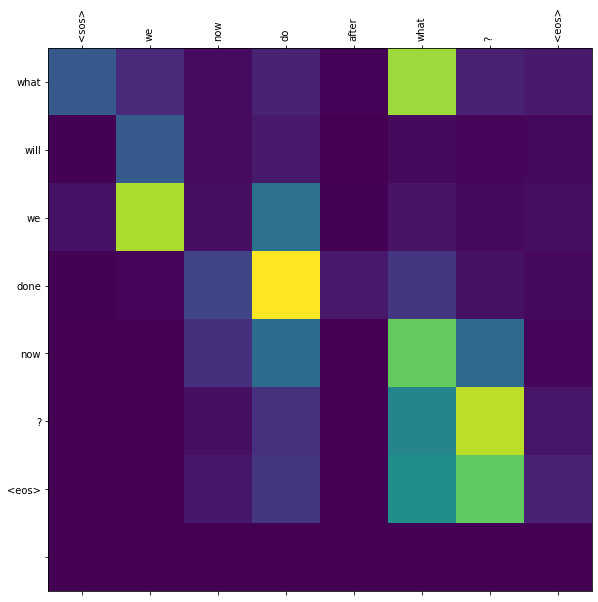


Input:          <sos> was fakhar munni step take . <eos>
Prediction:     fakhar took a step towards munni . <eos> 
Ground truth:   fakhar took a step towards munni .


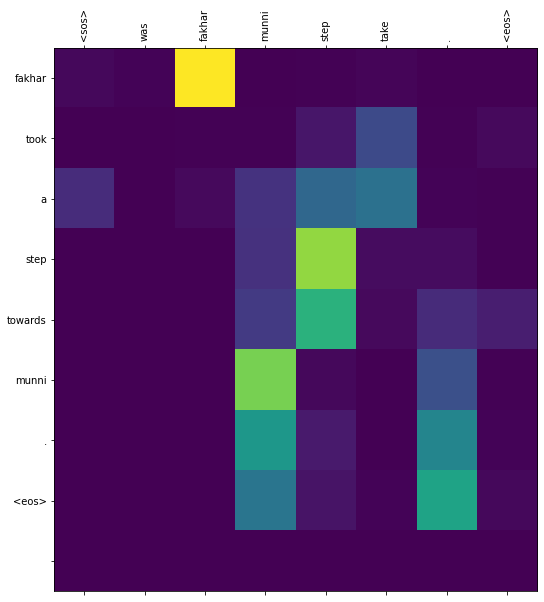


Input:          <sos> careful not yourself cut be . <eos>
Prediction:     be careful not to cut yourself . <eos> 
Ground truth:   be careful not to cut yourself .


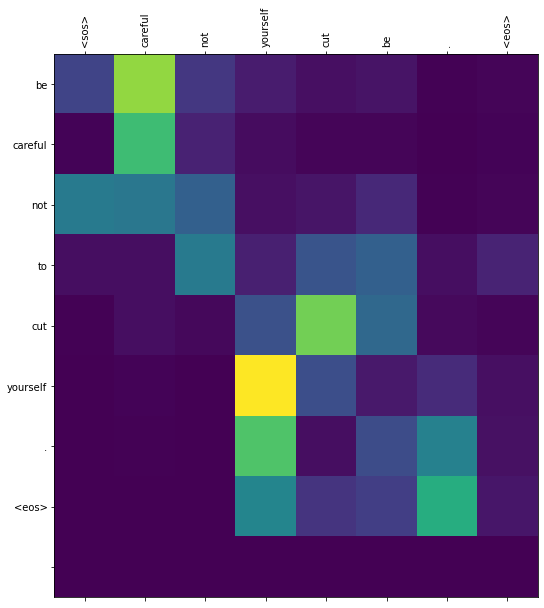


Input:          <sos> i just hope was qasim suffer not . <eos>
Prediction:     i just hope qasim did not suffer . <eos> 
Ground truth:   i just hope qasim did not suffer .


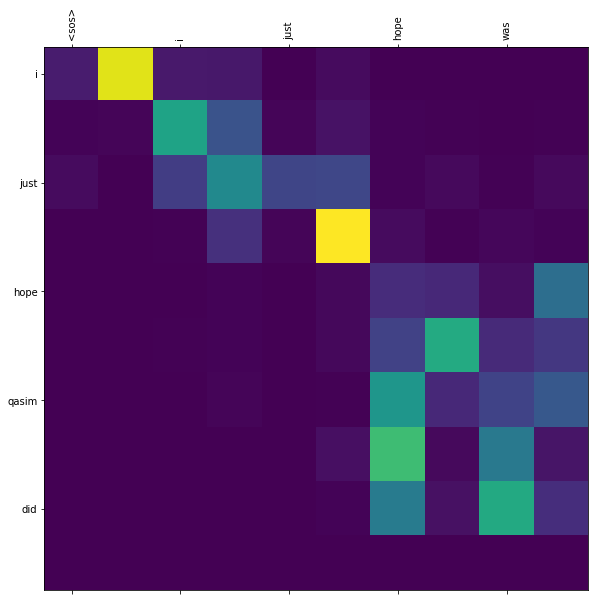


Input:          <sos> i now lunch eat want . <eos>
Prediction:     i want to eat lunch now . <eos> 
Ground truth:   i want to eat lunch now .


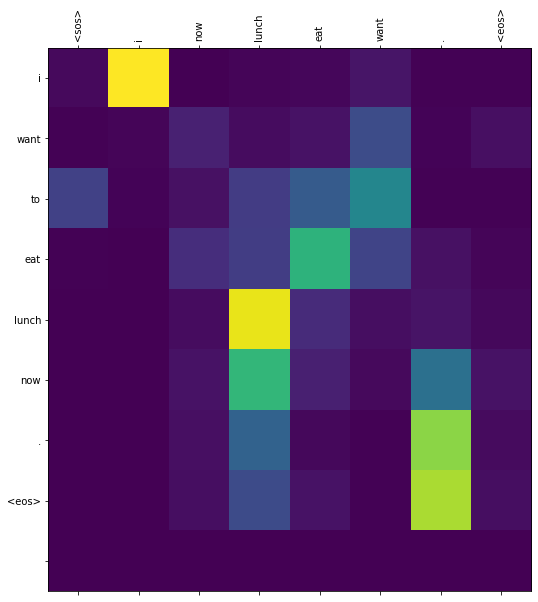


Input:          <sos> she work enjoy full after now . <eos>
Prediction:     she will have been enjoying her work . <eos> 
Ground truth:   she will have been enjoying her work .


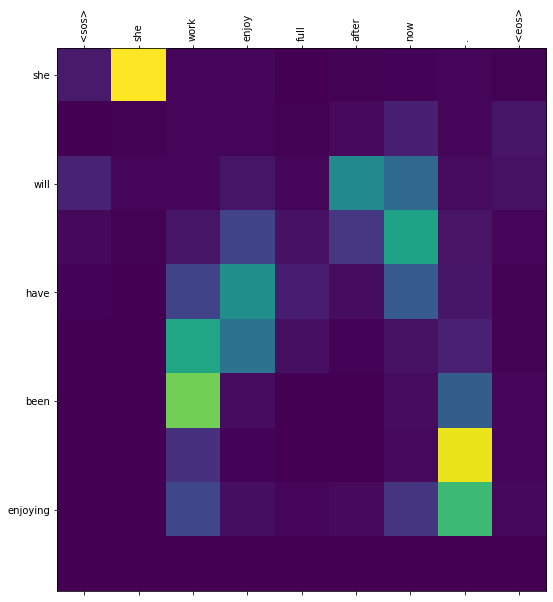


Input:          <sos> we rahib follow after . <eos>
Prediction:     we will follow rahib . <eos> 
Ground truth:   we will follow rahib .


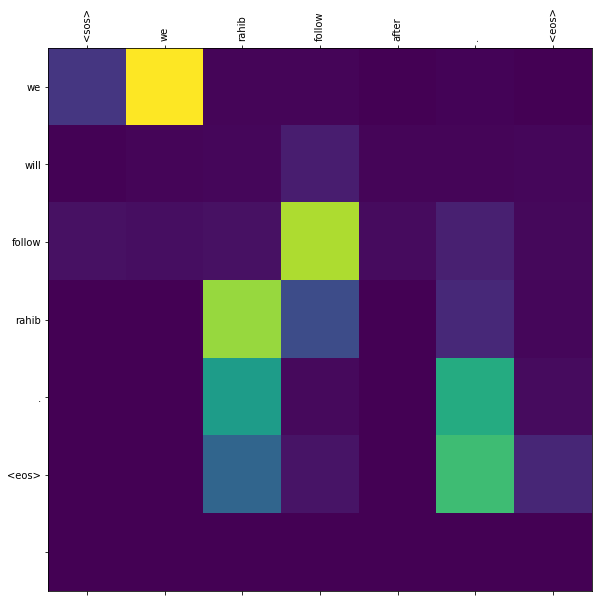


Input:          <sos> fazal i still karachi live . <eos>
Prediction:     fazal and i still live in karachi . <eos> 
Ground truth:   fazal and i still live in karachi .


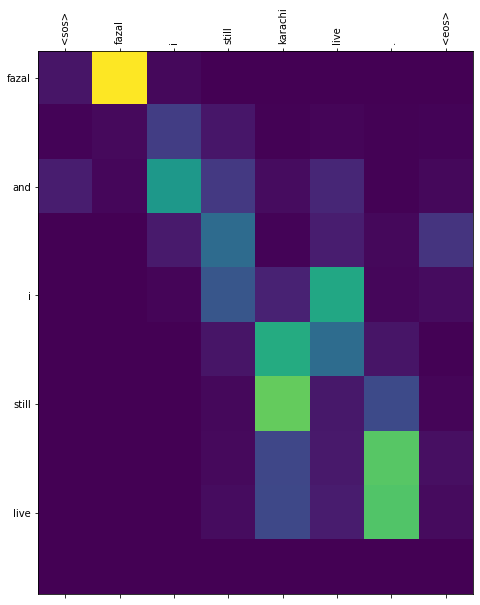


Input:          <sos> was waheed curtains open pull . <eos>
Prediction:     waheed pulled the curtains open . <eos> 
Ground truth:   waheed pulled the curtains open .


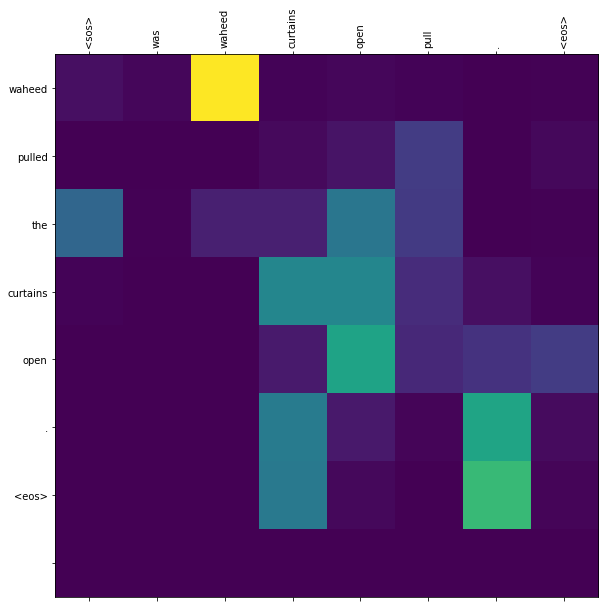


Input:          <sos> i doubt umais that foolish be . <eos>
Prediction:     i doubt umais would be that that . <eos> 
Ground truth:   i doubt umais would be that foolish .


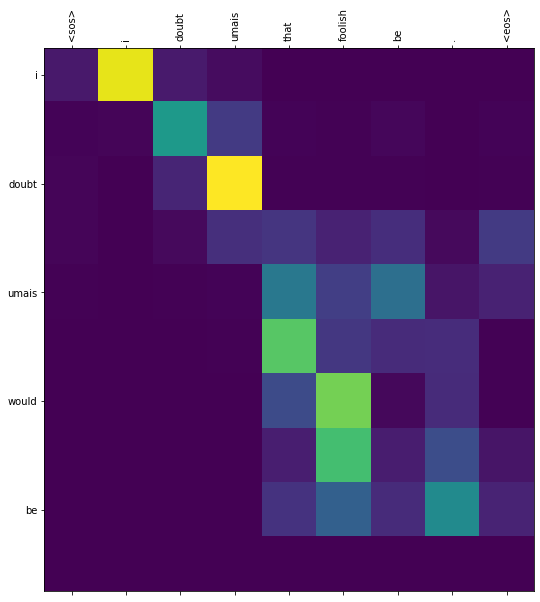


Input:          <sos> was ghafoor wealthy not . <eos>
Prediction:     ghafoor was not wealthy . <eos> 
Ground truth:   ghafoor was not wealthy .


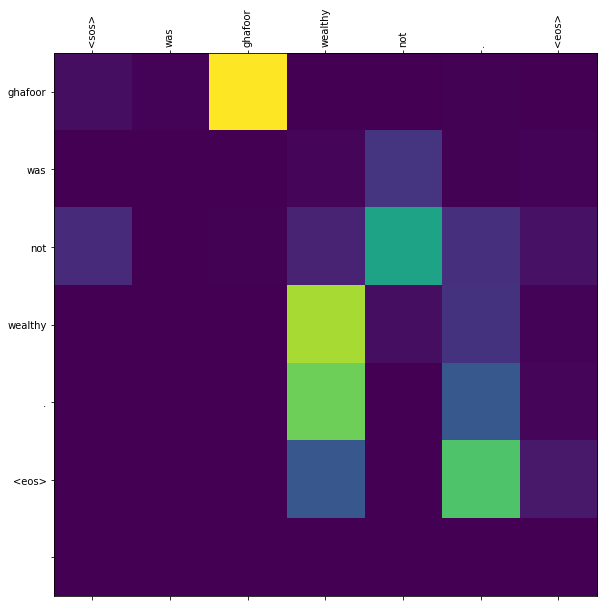


Input:          <sos> me you some tea get let . <eos>
Prediction:     let me get you some tea . <eos> 
Ground truth:   let me get you some tea .


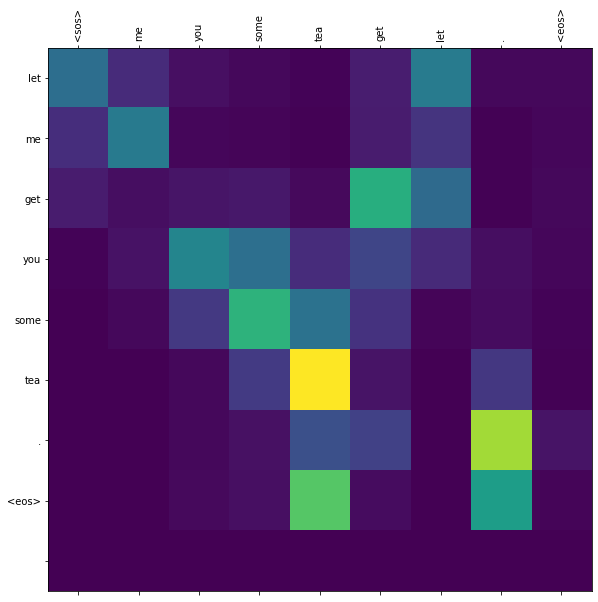


Input:          <sos> i already so do start full . <eos>
Prediction:     i have already started to do so . <eos> 
Ground truth:   i have already started to do so .


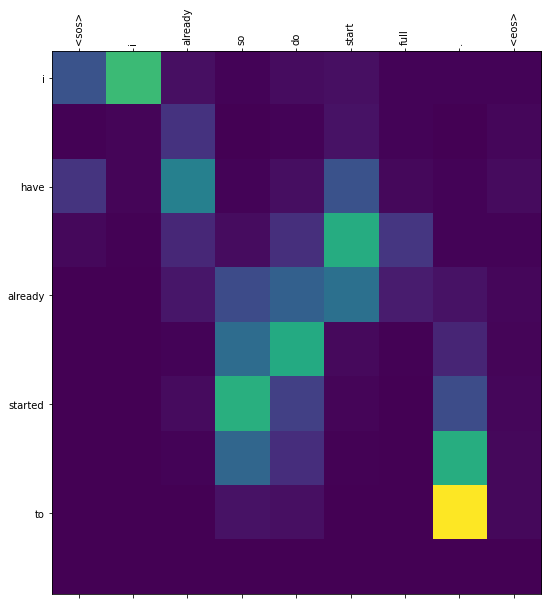


Input:          <sos> was i facts get had . <eos>
Prediction:     i had to get the facts . <eos> 
Ground truth:   i had to get the facts .


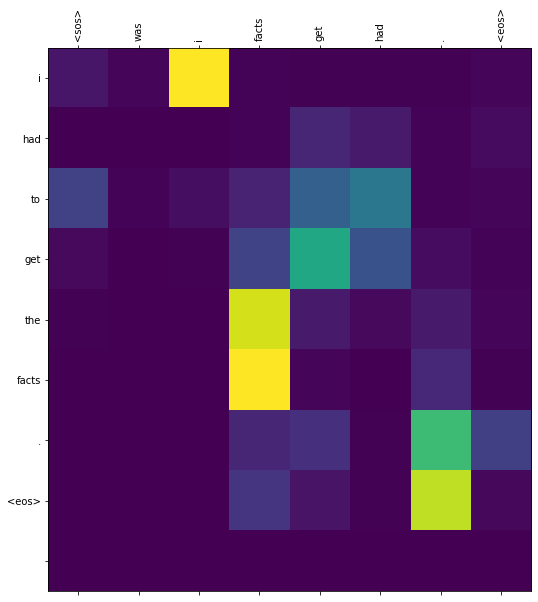


Input:          <sos> it just unreal seem . <eos>
Prediction:     it just seems unreal . <eos> 
Ground truth:   it just seems unreal .


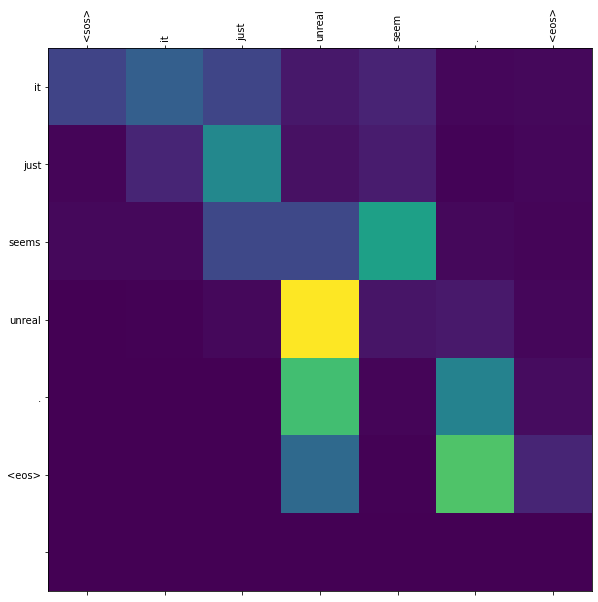


Input:          <sos> was they jalib ever find yes no ? <eos>
Prediction:     did they ever find jalib ? <eos> 
Ground truth:   did they ever find jalib ?


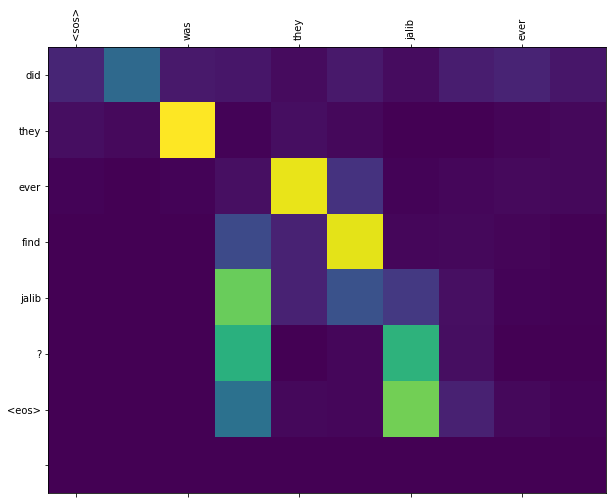


Input:          <sos> you it know . <eos>
Prediction:     you know it . <eos> 
Ground truth:   you know it .


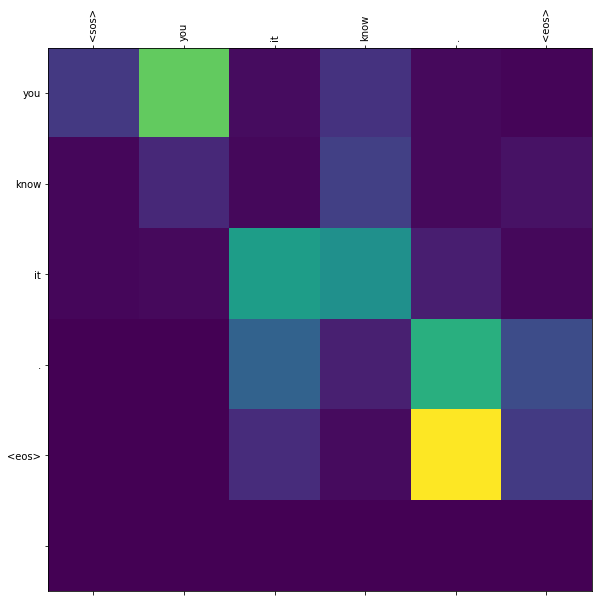


Input:          <sos> was i calm stay try . <eos>
Prediction:     i tried to stay calm . <eos> 
Ground truth:   i tried to stay calm .


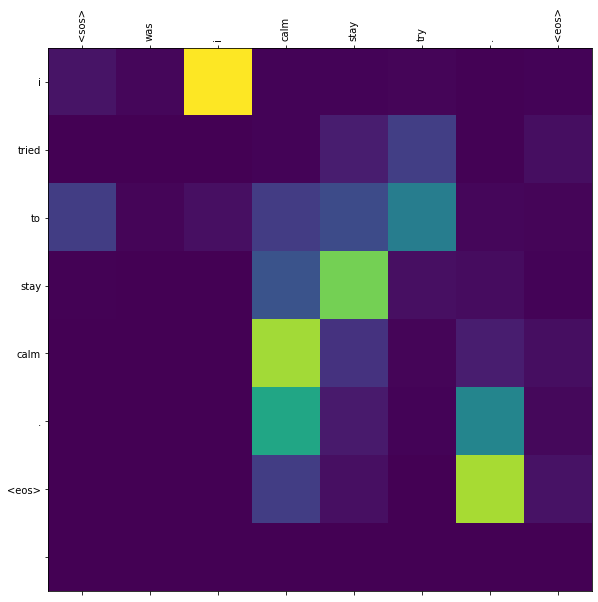


Input:          <sos> was we other sight lose . <eos>
Prediction:     we lost sight of each other . <eos> 
Ground truth:   we lost sight of each other .


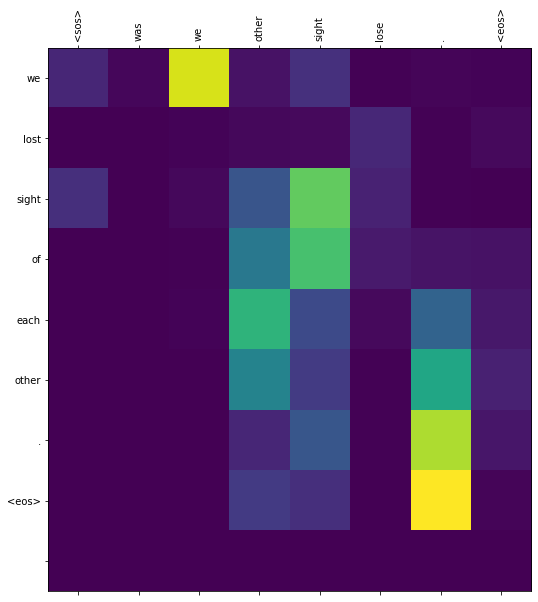


Input:          <sos> i you save after . <eos>
Prediction:     i will save you . <eos> 
Ground truth:   i will save you .


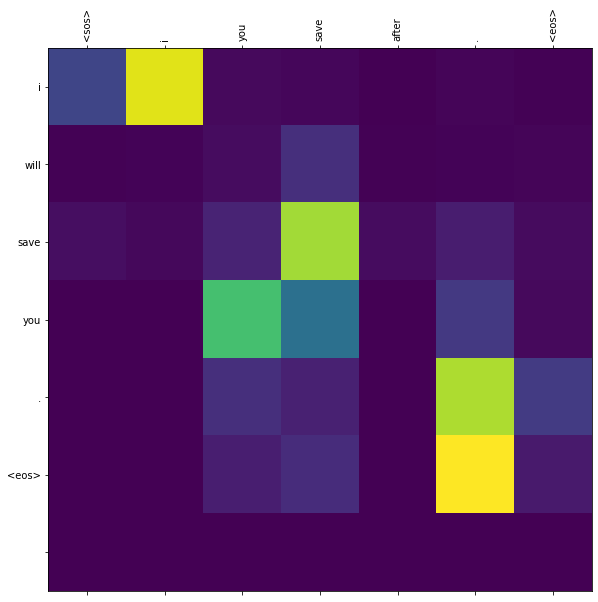


Input:          <sos> i dream now yes no ? <eos>
Prediction:     am i dreaming ? <eos> 
Ground truth:   am i dreaming ?


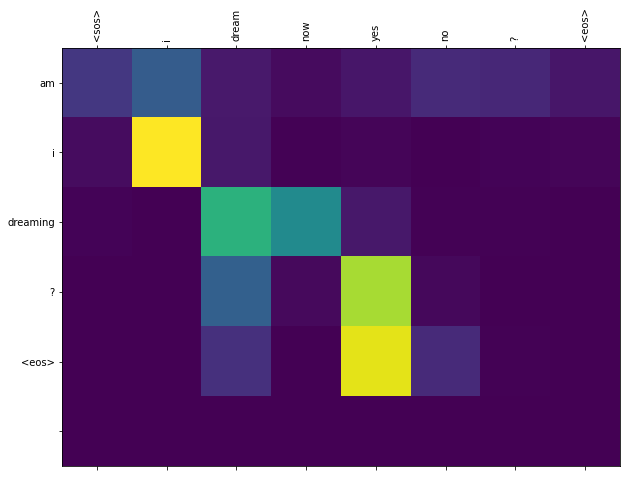


Input:          <sos> madni courteous . <eos>
Prediction:     madni is courteous . <eos> 
Ground truth:   madni is courteous .


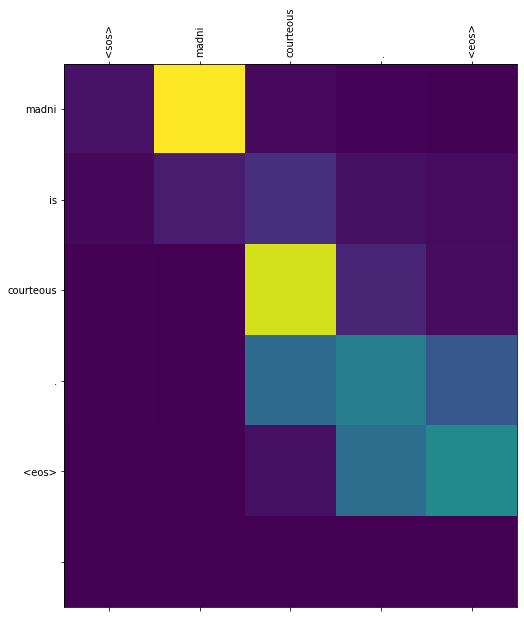


Input:          <sos> was the train late arrive full now not . <eos>
Prediction:     the train had not been arriving late . <eos> 
Ground truth:   the train had not been arriving late .


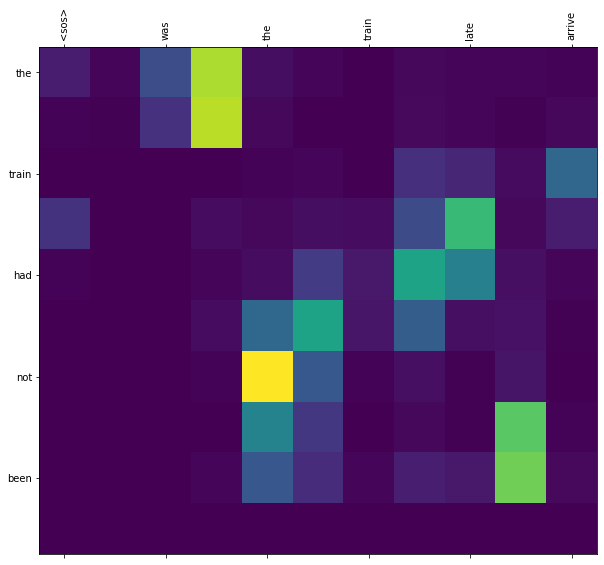


Input:          <sos> was snake box move in to full not . <eos>
Prediction:     the snake had not moved in to the box . <eos> 
Ground truth:   the snake had not moved in to the box .


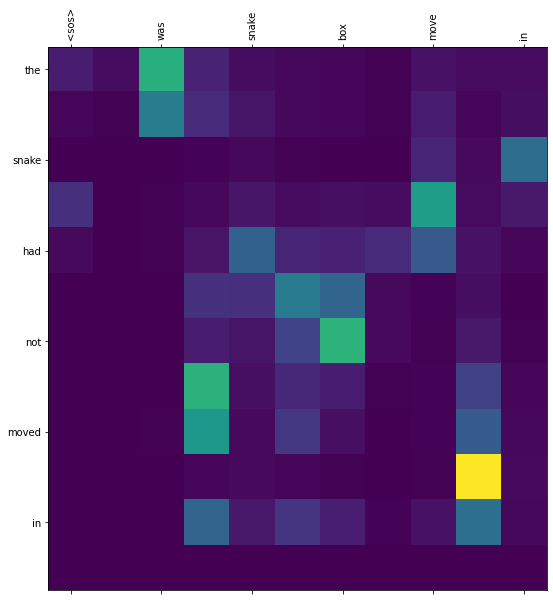


Input:          <sos> i it three tickets have . <eos>
Prediction:     i have three tickets for it . <eos> 
Ground truth:   i have three tickets for it .


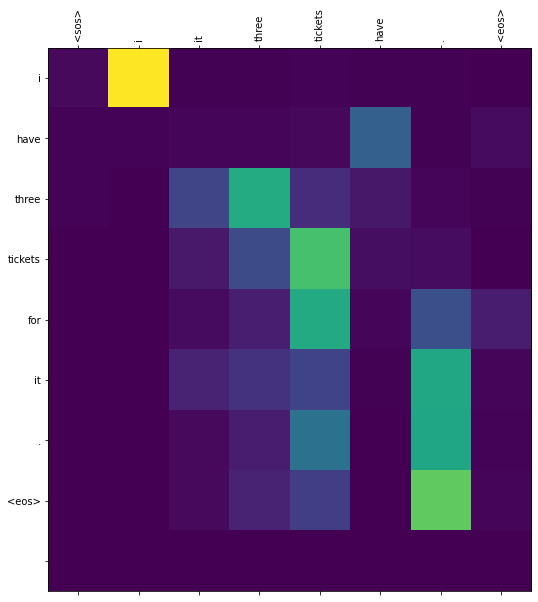


Input:          <sos> was i good idea then hit . <eos>
Prediction:     i hit upon a good idea then . <eos> 
Ground truth:   i hit upon a good idea then .


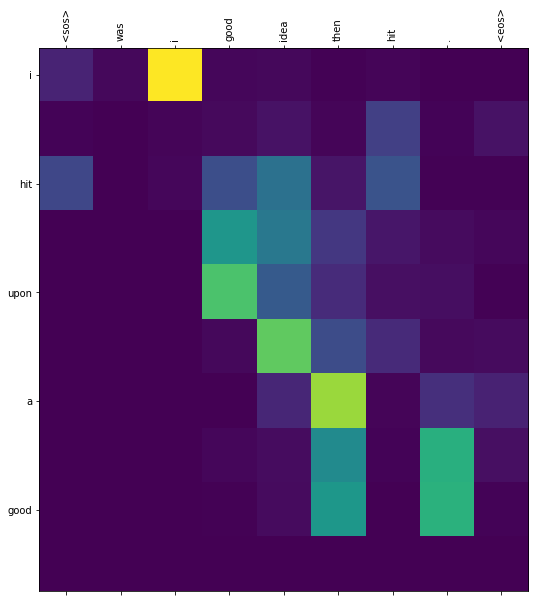


Input:          <sos> cat water drink full now yes no ? <eos>
Prediction:     has the cat been drinking water . <eos> 
Ground truth:   has the cat been drinking water .


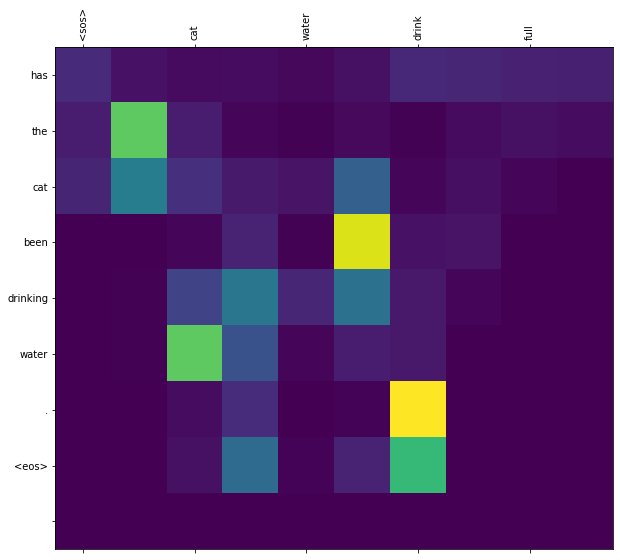


Input:          <sos> we move keep get full . <eos>
Prediction:     we have got to keep moving . <eos> 
Ground truth:   we have got to keep moving .


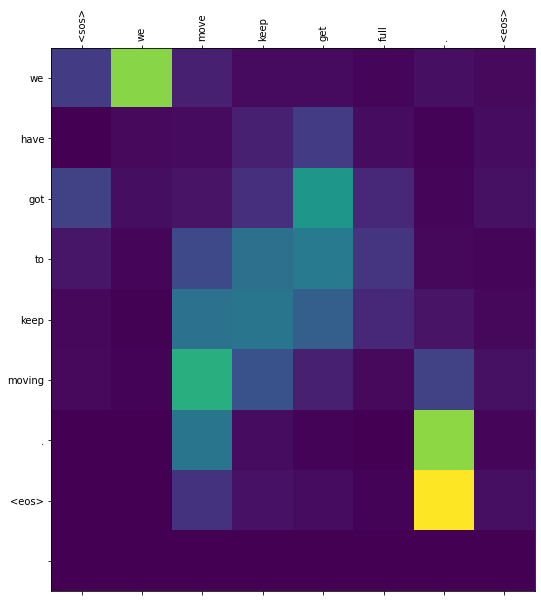


Input:          <sos> i your judgement it leave after . <eos>
Prediction:     i will leave it to your judgement . <eos> 
Ground truth:   i will leave it to your judgement .


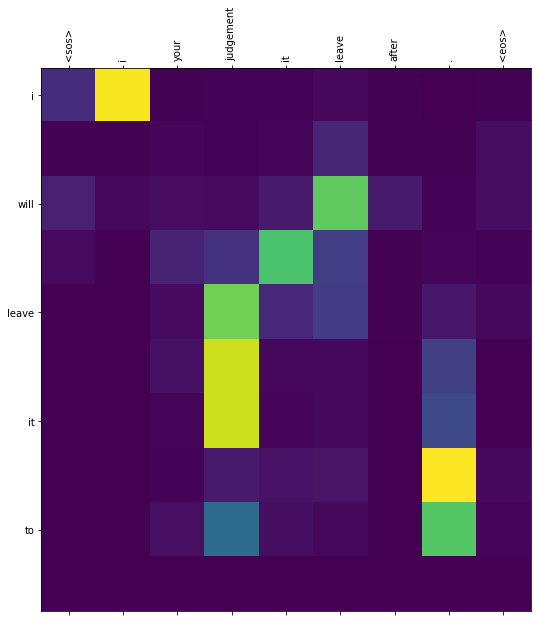


Input:          <sos> maha too much makeup wear . <eos>
Prediction:     maha wears too much makeup . <eos> 
Ground truth:   maha wears too much makeup .


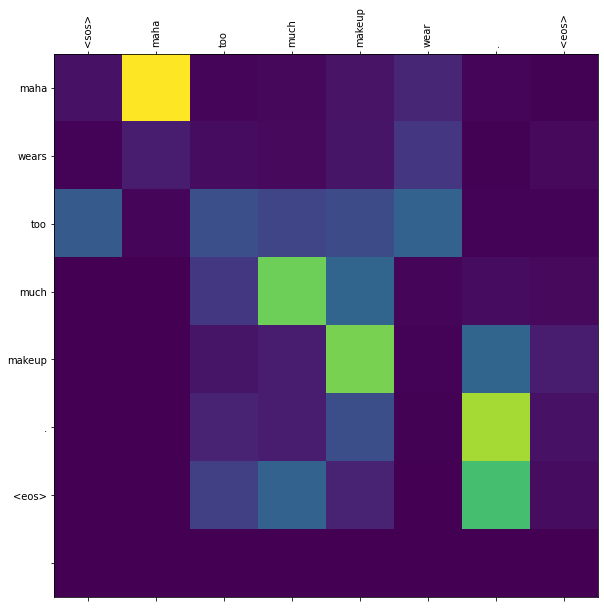


Input:          <sos> i hope mahi us help after . <eos>
Prediction:     i hope mahi will help us . <eos> 
Ground truth:   i hope mahi will help us .


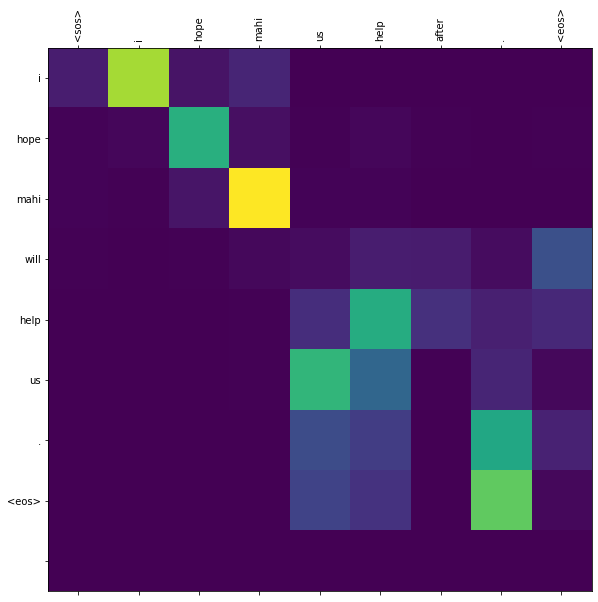


Input:          <sos> was he high wages pay promise . <eos>
Prediction:     he promised to pay wages . <eos> 
Ground truth:   he promised to pay us high wages .


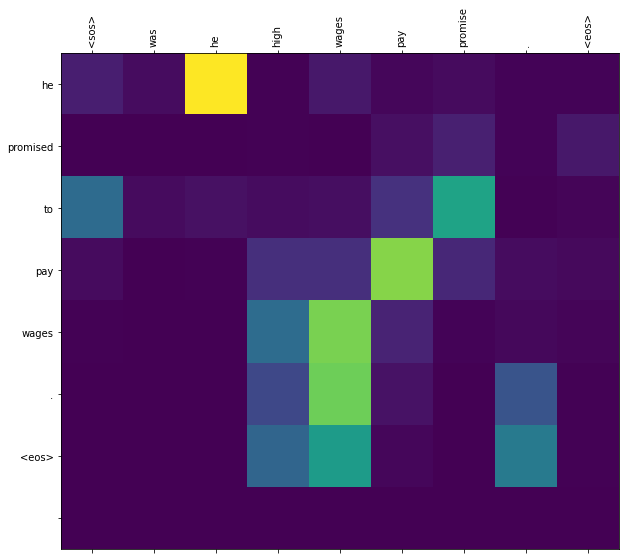


Input:          <sos> was you me need yes no ? <eos>
Prediction:     did you need me ? <eos> 
Ground truth:   did you need me ?


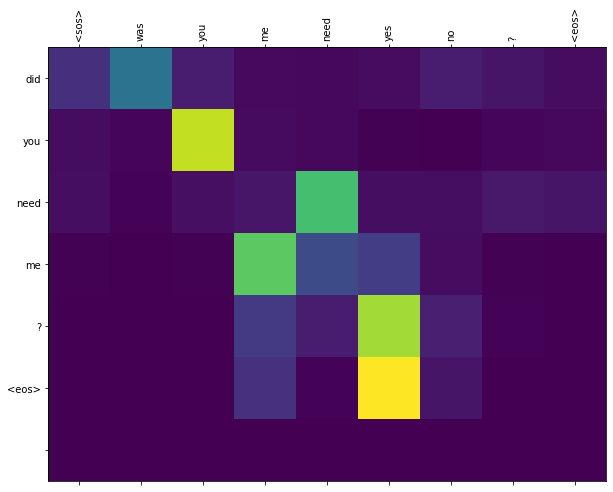


Input:          <sos> jibran honest . <eos>
Prediction:     jibran is honest . <eos> 
Ground truth:   jibran is honest .


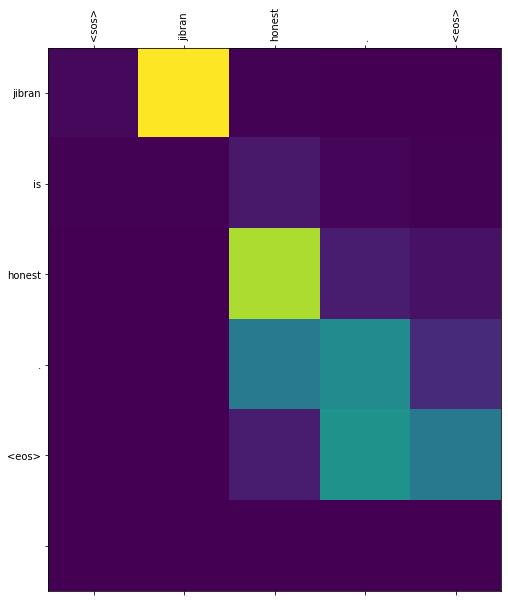


Input:          <sos> zahid bad boy . <eos>
Prediction:     zahid is a bad boy . <eos> 
Ground truth:   zahid is a bad boy .


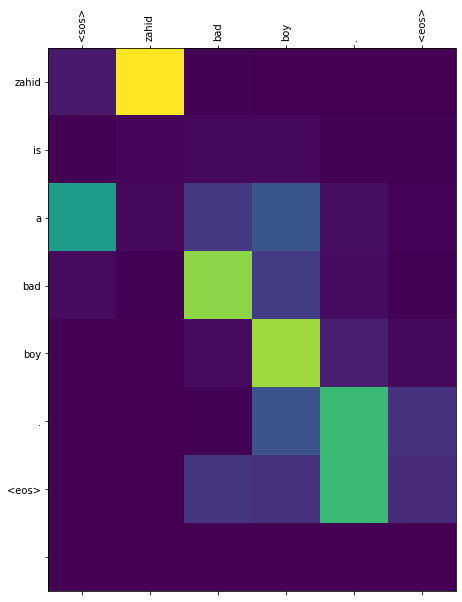


Input:          <sos> my foot really hurt . <eos>
Prediction:     my foot really hurts . <eos> 
Ground truth:   my foot really hurts .


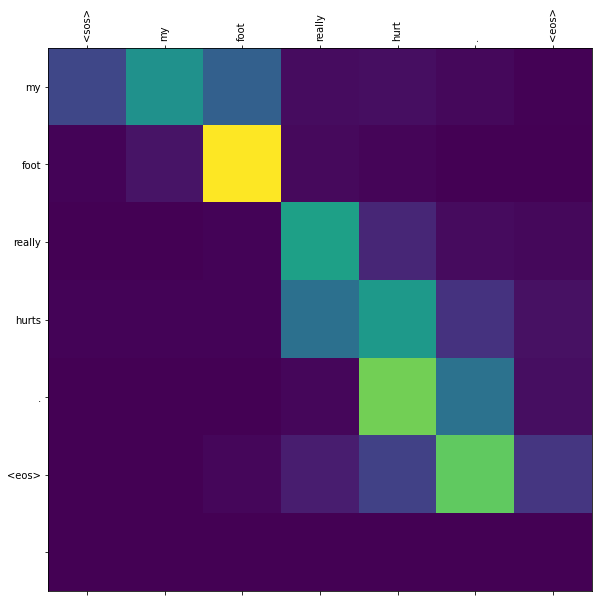


Input:          <sos> was nobody you talk tell . <eos>
Prediction:     nobody told you to you . <eos> 
Ground truth:   nobody told you to talk .


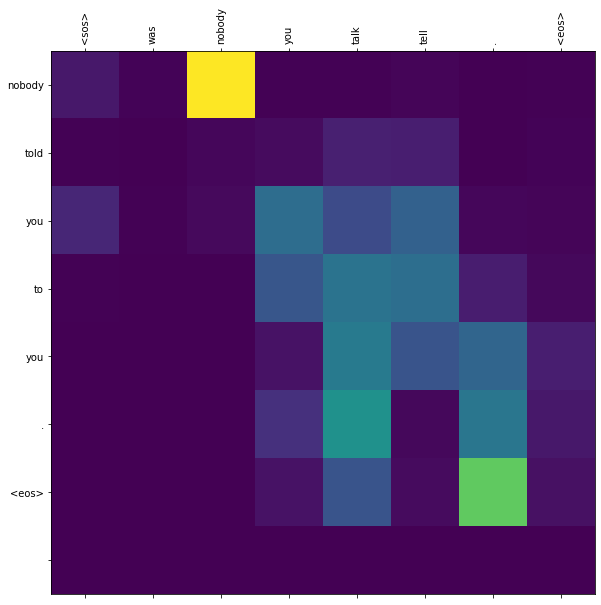


Input:          <sos> she twin . <eos>
Prediction:     she is a twin . <eos> 
Ground truth:   she is a twin .


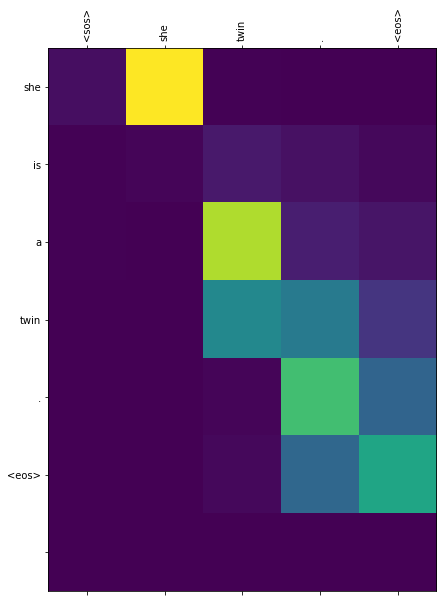


Input:          <sos> was i karachi born not . <eos>
Prediction:     i was not born in karachi . <eos> 
Ground truth:   i was not born in karachi .


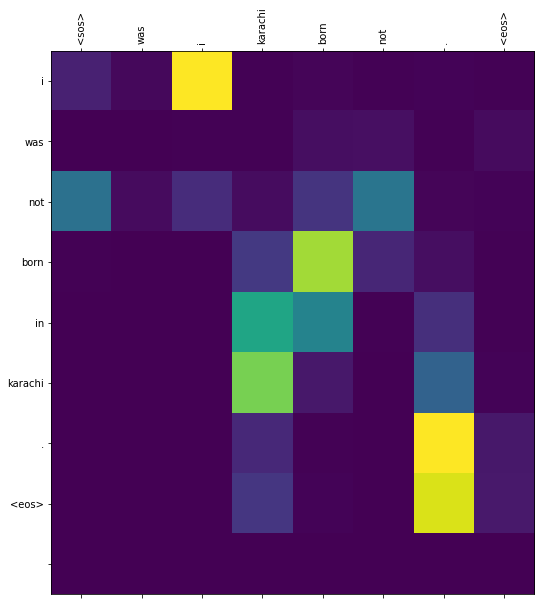


Input:          <sos> he novelist and poet . <eos>
Prediction:     he is a novelist and poet . <eos> 
Ground truth:   he is a novelist and poet .


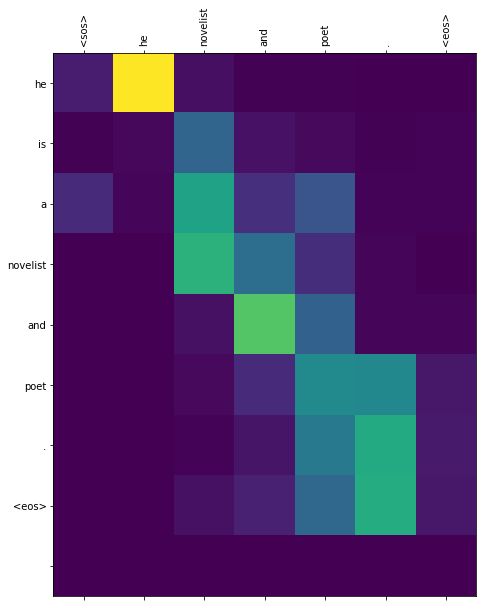


Input:          <sos> teacher reason ask full now . <eos>
Prediction:     teacher has been asking the reason . <eos> 
Ground truth:   teacher has been asking the reason .


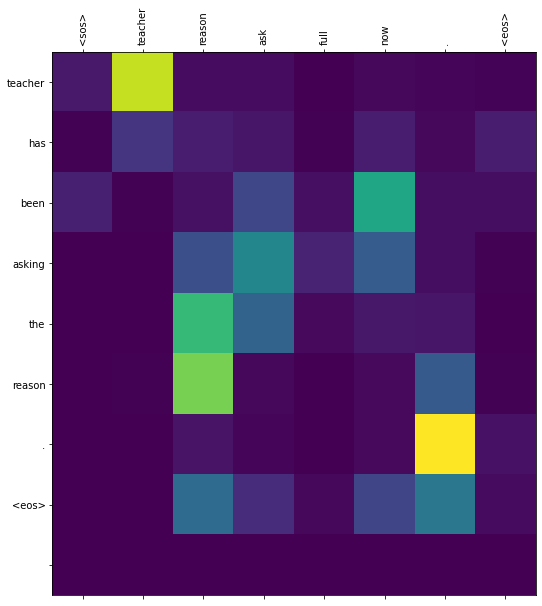


Input:          <sos> hassan festivals reads about full after . <eos>
Prediction:     hassan will have read about festivals . <eos> 
Ground truth:   hassan will have read about festivals .


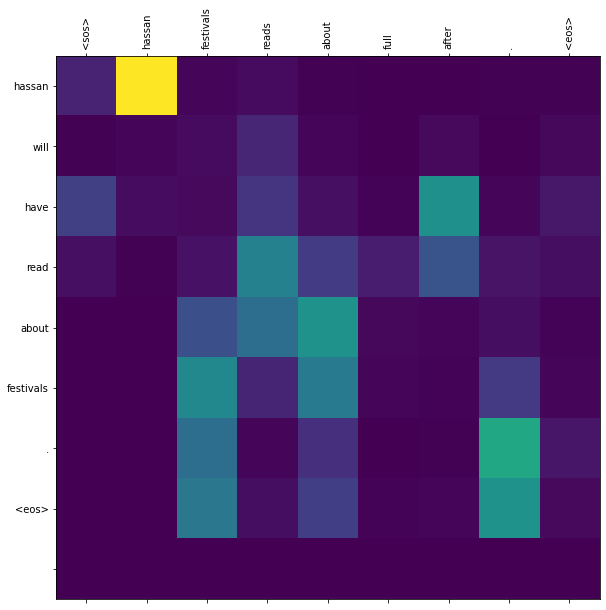


Input:          <sos> sana beautiful dress wear now . <eos>
Prediction:     sana is wearing a beautiful dress . <eos> 
Ground truth:   sana is wearing a beautiful dress .


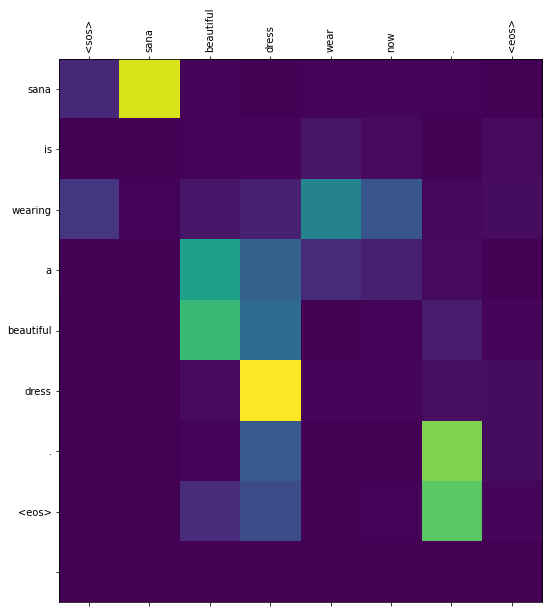


Input:          <sos> i never chinese food try full . <eos>
Prediction:     i have never tried chinese food . <eos> 
Ground truth:   i have never tried chinese food .


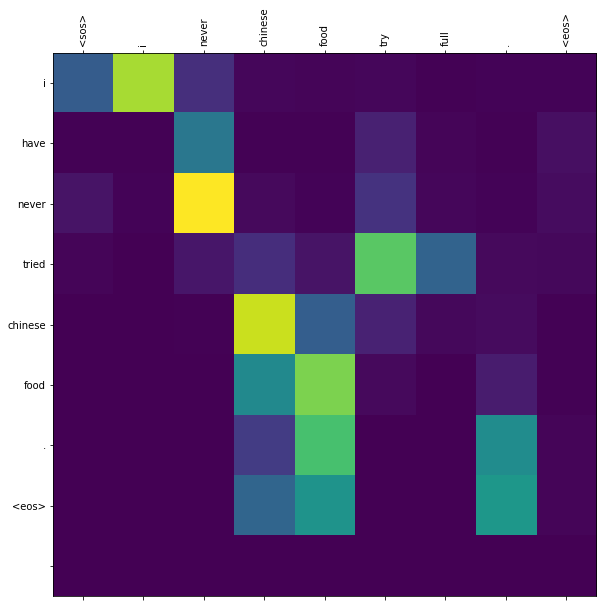


Input:          <sos> was arif maria cricket play full now yes no ? <eos>
Prediction:     had arif and maria been playing cricket . <eos> 
Ground truth:   had arif and maria been playing cricket .


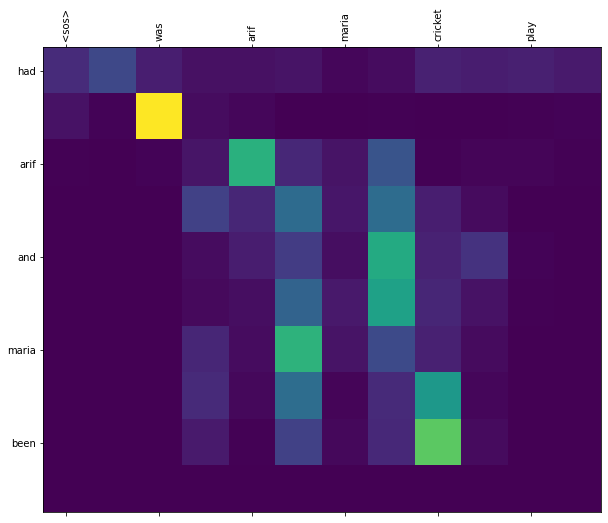


Input:          <sos> it very personal choice . <eos>
Prediction:     it is a very personal choice . <eos> 
Ground truth:   it is a very personal choice .


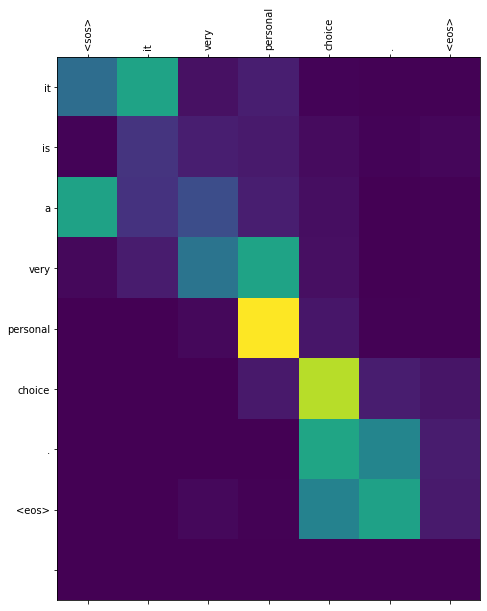


Input:          <sos> was faraz dinner arooj take . <eos>
Prediction:     faraz took arooj out to dinner . <eos> 
Ground truth:   faraz took arooj out to dinner .


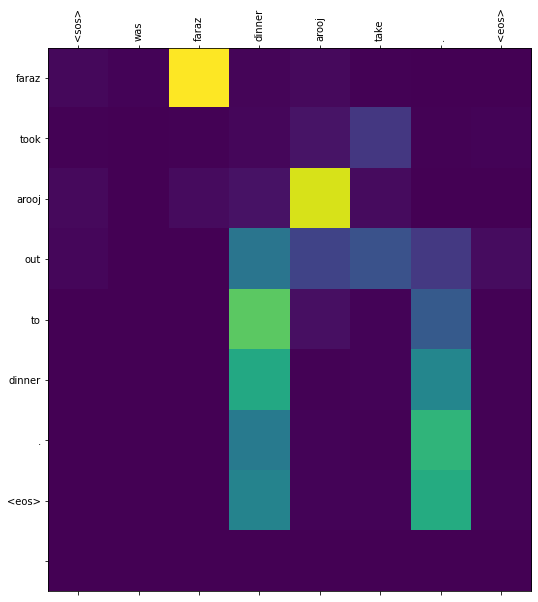


Input:          <sos> we action want . <eos>
Prediction:     we want action . <eos> 
Ground truth:   we want action .


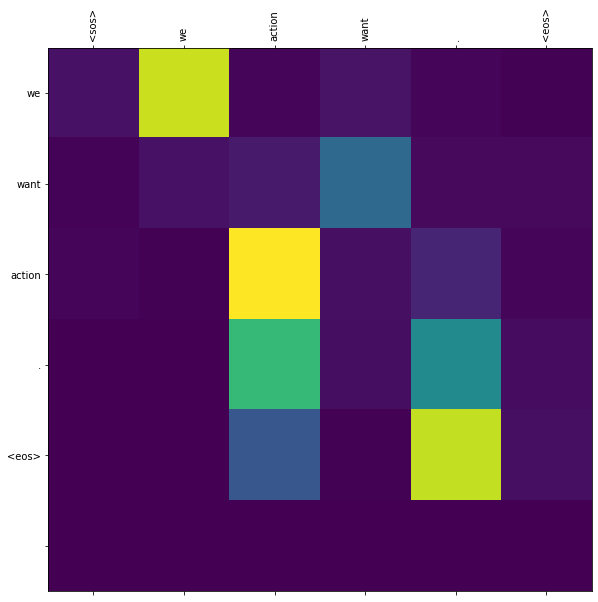


Input:          <sos> was ali then say what ? <eos>
Prediction:     what did ali said then ? <eos> 
Ground truth:   what did ali say then ?


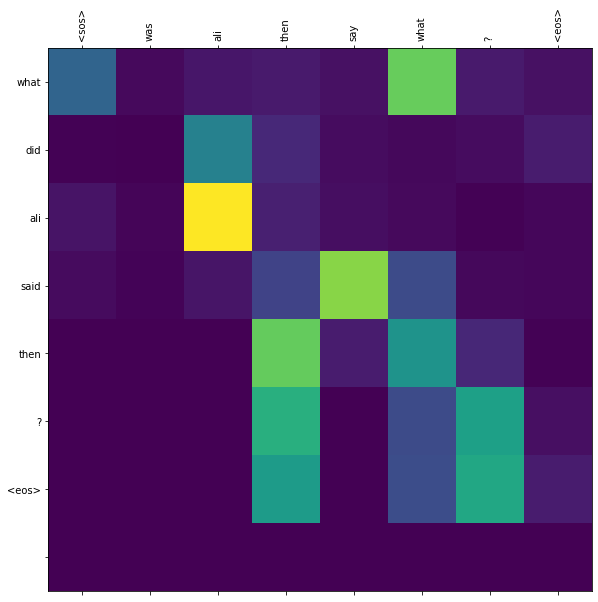


Input:          <sos> i work quickly do want . <eos>
Prediction:     i want to do quickly done . <eos> 
Ground truth:   i want the work done quickly .


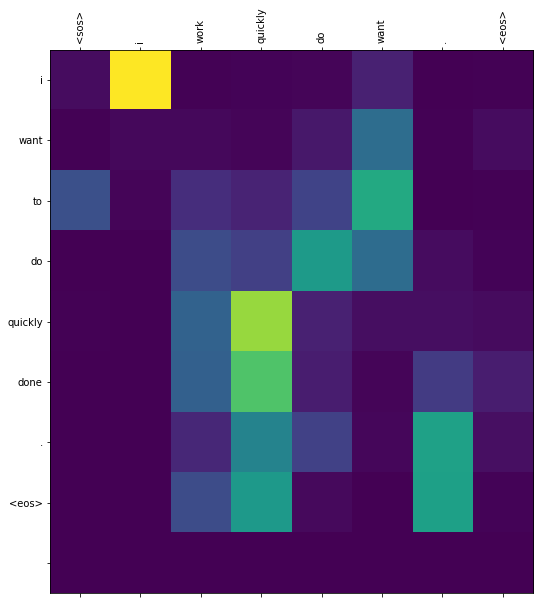


Input:          <sos> he his ankle hurt after . <eos>
Prediction:     he will hurt his ankle . <eos> 
Ground truth:   he will hurt his ankle .


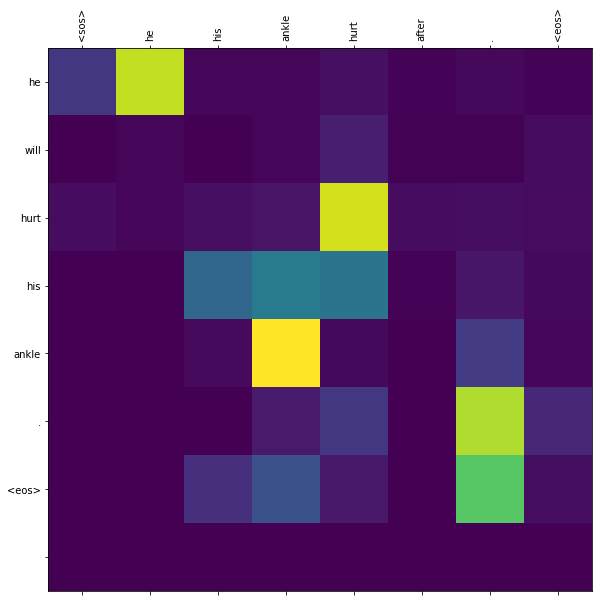


Input:          <sos> i my house hate . <eos>
Prediction:     i hate my house . <eos> 
Ground truth:   i hate my house .


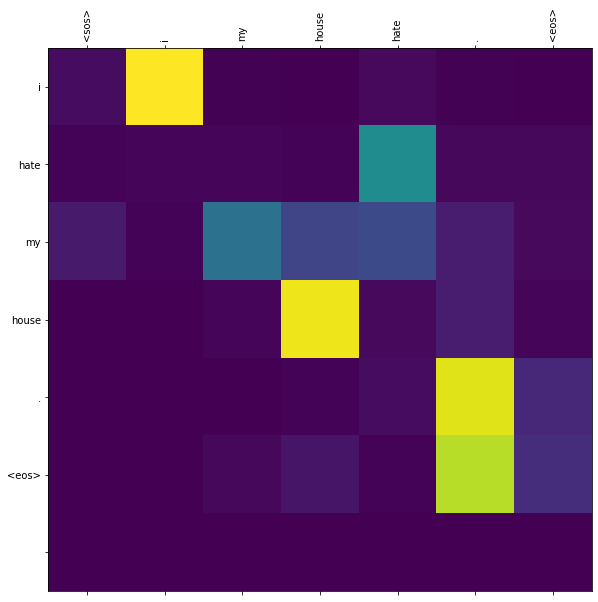


Input:          <sos> was i manan ago see . <eos>
Prediction:     i saw manan three hours ago . <eos> 
Ground truth:   i saw manan three hours ago .


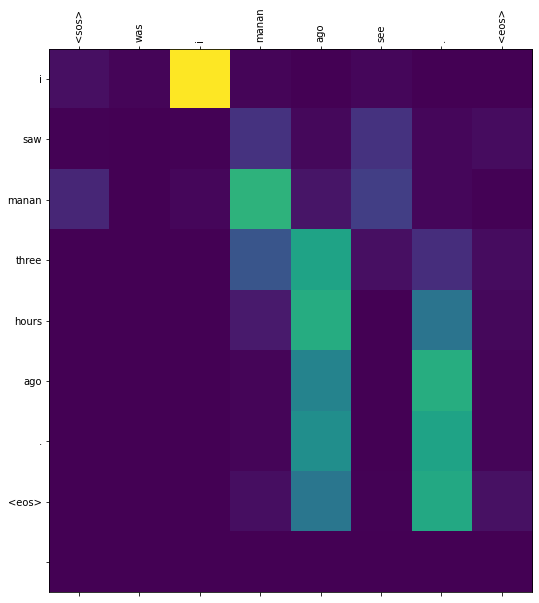


Input:          <sos> najeeb delirious . <eos>
Prediction:     najeeb is delirious . <eos> 
Ground truth:   najeeb is delirious .


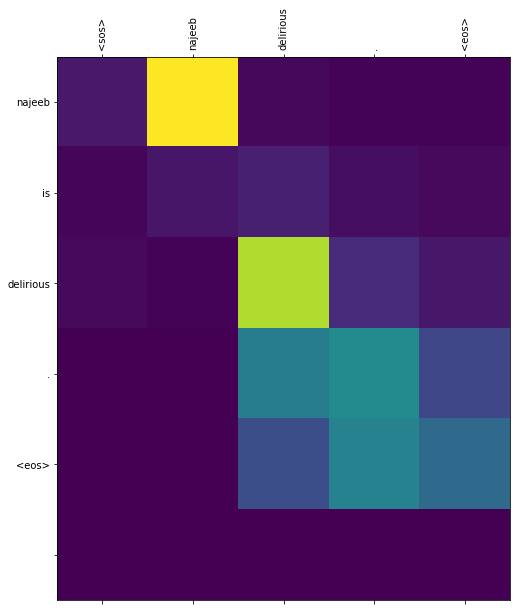


Input:          <sos> i you everywhere see . <eos>
Prediction:     i see you everywhere . <eos> 
Ground truth:   i see you everywhere .


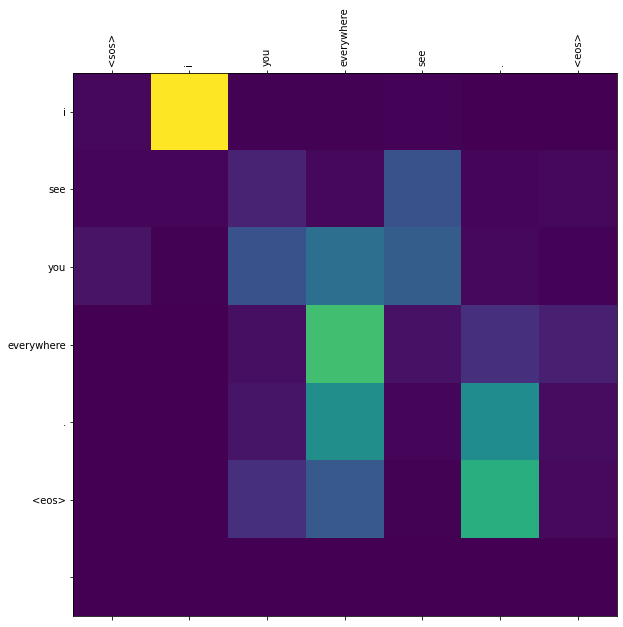


Input:          <sos> was they it unanimously agree . <eos>
Prediction:     they agreed to it unanimously . <eos> 
Ground truth:   they agreed to it unanimously .


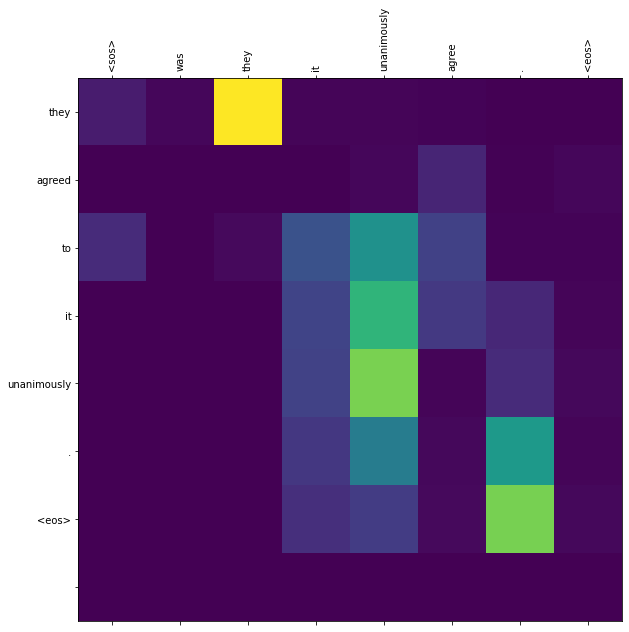


Input:          <sos> was she apple buy yes no ? <eos>
Prediction:     did she buy apple ? <eos> 
Ground truth:   did she buy apple .


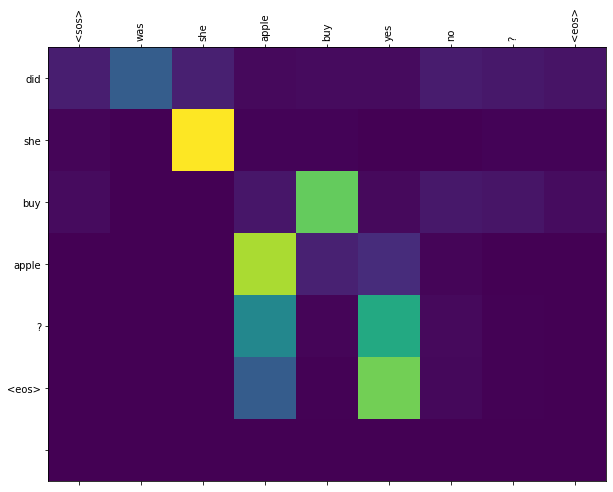


Input:          <sos> i zabhi tell get full . <eos>
Prediction:     i have got to tell zabhi . <eos> 
Ground truth:   i have got to tell zabhi .


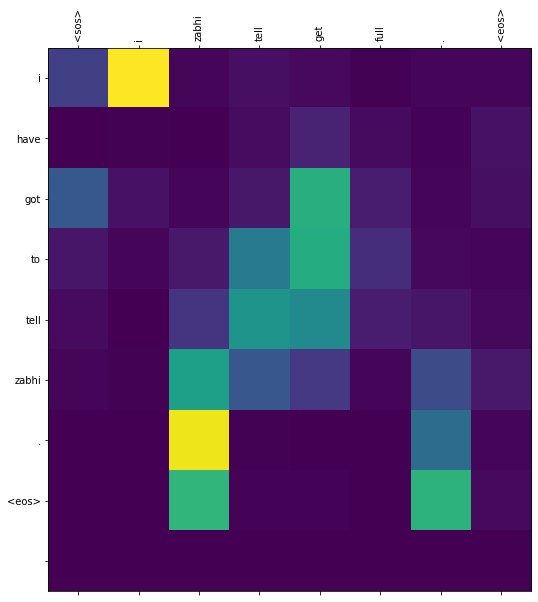


Input:          <sos> they us anymore track not . <eos>
Prediction:     they can not track us anymore . <eos> 
Ground truth:   they can not track us anymore .


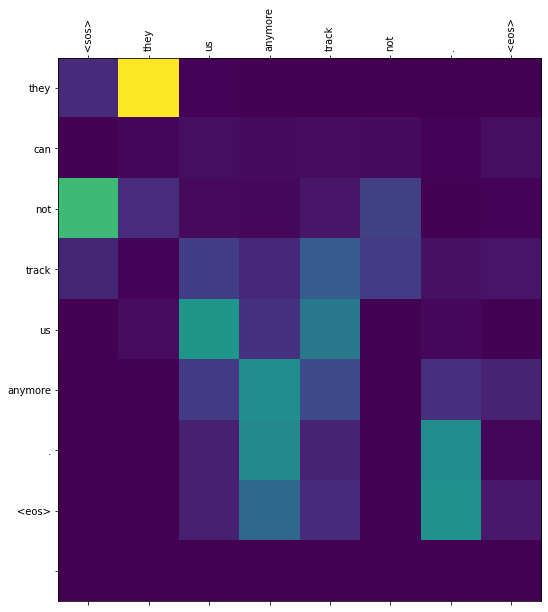


Input:          <sos> robin probably truthful be after . <eos>
Prediction:     robin will probably be truthful . <eos> 
Ground truth:   robin will probably be truthful .


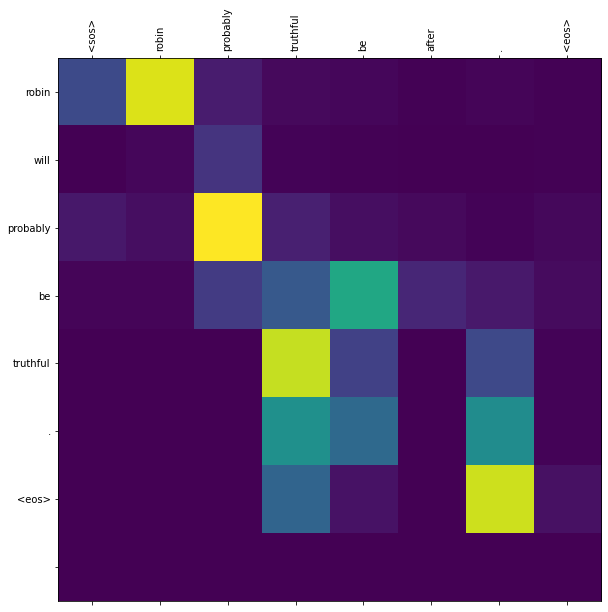


Input:          <sos> i know that nazeer busy . <eos>
Prediction:     i know that nazeer is busy . <eos> 
Ground truth:   i know that nazeer is busy .


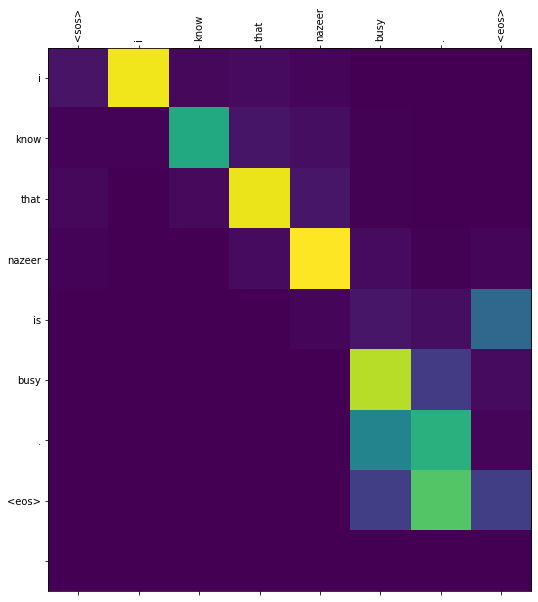


Input:          <sos> was he resign . <eos>
Prediction:     he resigned . <eos> 
Ground truth:   he resigned .


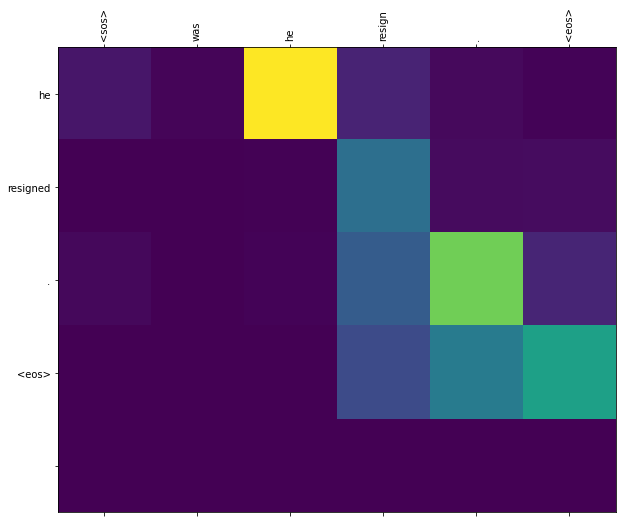


Input:          <sos> sanaullah stay here very long not . <eos>
Prediction:     sanaullah would not stay here very long . <eos> 
Ground truth:   sanaullah would not stay here very long .


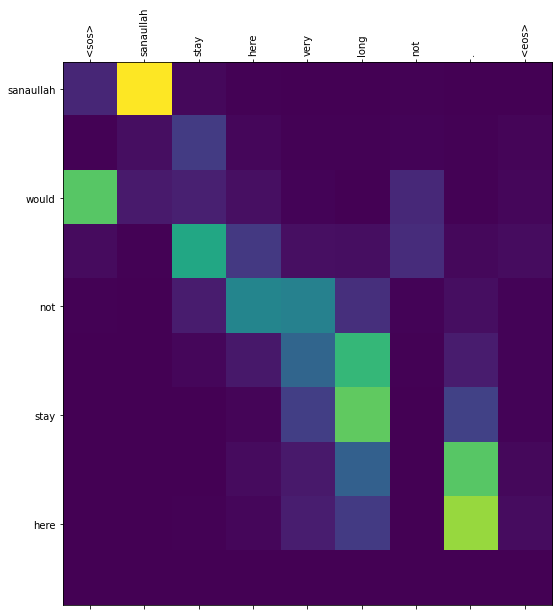


Input:          <sos> i fish eat after . <eos>
Prediction:     i will eat fish . <eos> 
Ground truth:   i will eat fish .


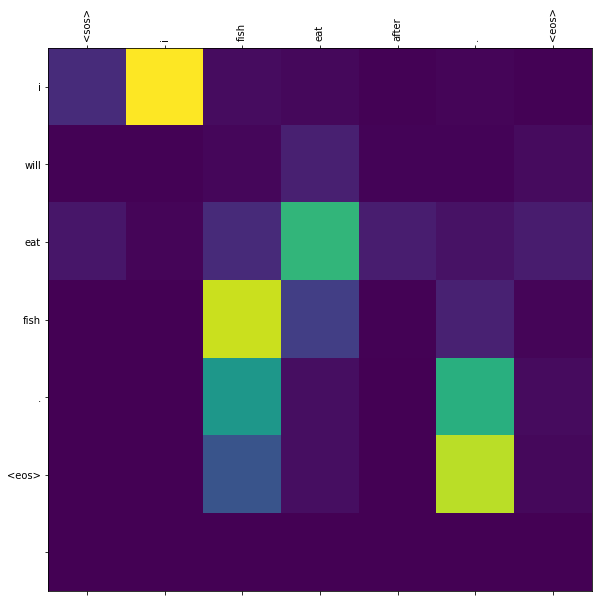


Input:          <sos> was aleem discontent seem . <eos>
Prediction:     aleem seemed discontented . <eos> 
Ground truth:   aleem seemed discontented .


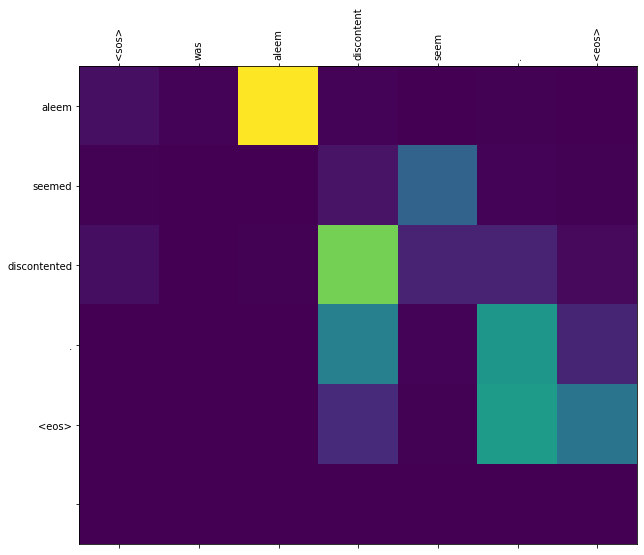

In [ ]:
for inp_batch, targ_batch in valid_dataset.take(100):
    for inp, targ in zip(inp_batch, targ_batch):
        sentence = preprocess_sequence(inp, inp_lang)
        ground_truth = preprocess_sequence(targ, targ_lang)
        translate(sentence, ground_truth, plot_weights=True)
        print()
        break

In [ ]:
groundt=list()
predict=list()

numsamples=17000

for inp_batch, targ_batch in valid_dataset.take(numsamples):
    for inp, targ in zip(inp_batch, targ_batch):
        sentence = preprocess_sequence(inp, inp_lang)
        ground_truth = preprocess_sequence(targ, targ_lang)
        s,r,g=gettranslation(sentence, ground_truth, plot_weights=False)
        groundt.append(ground_truth)
        predict.append(r)
        break

In [ ]:
j=0
for i in groundt:
  print(i)
  j=j+1

moon hardly ever acts his age .
he did not even say goodbye .
i will do as you suggested .
they will get one soon enough .
just go back home .
she cried as she read the letter .
hafeez is not looking very well .
amir is just watching television .
moon wanted to copy my homework .
i have got some good news .
i wanted to show uqbah your book .
did fisherman camp on a beach .
qasim said that adila would not cry .
robin told gazala about his father .
is ayesha not going to school .
it is a really bad situation .
umais helped halima escape from jail .
husnain said he could not recall .
i am playing golf .
he has not eaten food .
had saqib not been dusting the furniture .
i dropped the cup .
he is an excellent tennis player .
go outside .
you can not live here anymore .
give my best to your family .
habibullah tried to conceal his anger .
buzdar always gets here on time .
i know that shazim is naive .
sameer had a very difficult year .
ajab sealed the room .
make sure you close the windows .

In [ ]:
j

1065

In [ ]:
len(groundt)

1065

In [ ]:
len(predict)

1065

In [ ]:
predict

['moon hardly ever acts his age . <eos> ',
 'he did not even say goodbye . <eos> ',
 'i will do as you suggested . <eos> ',
 'they will soon get one soon soon enough . <eos> ',
 'just go back home . <eos> ',
 'she cried as she read the letter . <eos> ',
 'hafeez is not looking very well . <eos> ',
 'amir is just watching television . <eos> ',
 'moon wanted to copy my homework . <eos> ',
 'i have got good news . <eos> ',
 'i wanted to show you all your book . <eos> ',
 'did fisherman camp on a beach . <eos> ',
 'qasim said that adila would not cry . <eos> ',
 'robin told gazala about his father . <eos> ',
 'is ayesha not going to school . <eos> ',
 'it is a really bad situation . <eos> ',
 'umais and halima helped school in jail . <eos> ',
 'husnain said he could not recall . <eos> ',
 'i am playing golf . <eos> ',
 'he has not eaten food . <eos> ',
 'had saqib not been dusting the furniture . <eos> ',
 'i dropped the cup . <eos> ',
 'he is an excellent tennis player . <eos> ',
 'go out

In [ ]:
file1 = open("/content/PSL_to_ENG_predict_badanau.txt","w")

In [ ]:
z=0
for i in predict:
  file1.writelines(i+'\n')
  z=z+1
file1.close()

In [ ]:
file2 = open("/content/PSL_to_ENG_Ground_badanau.txt","w")

In [ ]:
z=0
for i in groundt:
  file2.writelines(i+'\n')
  z=z+1
file1.close()